In [59]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [60]:
import os 
os.chdir('/kaggle/input/diffdata') #Define Data directory

In [61]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.

        Parameters:
        - hr_images (list of ndarray): High-resolution images.
        - lr_images (list of ndarray): Low-resolution images.
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = [torch.tensor(img, dtype=torch.float32) for img in hr_images]
        self.lr_images = [torch.tensor(img, dtype=torch.float32) for img in lr_images]
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.

        Parameters:
        - idx (int): Index of the image to retrieve.

        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Ensure LR and HR images are 4D (N, C, H, W) for interpolation
        if len(lr.shape) == 2:  # If single channel 2D image
            lr = lr.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            hr = hr.unsqueeze(0).unsqueeze(0)
        elif len(lr.shape) == 3:  # If 3D (C, H, W) image
            lr = lr.unsqueeze(0)
            hr = hr.unsqueeze(0)
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr, size=hr.shape[2:], mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr.squeeze(0)

In [63]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [65]:
def check_for_nans(data_loader):
    for batch_idx, (lr, hr) in enumerate(data_loader):
        if torch.isnan(lr).any():
            print(f"NaN values found in LR images in batch {batch_idx}")
        if torch.isnan(hr).any():
            print(f"NaN values found in HR images in batch {batch_idx}")

check_for_nans(train_dataloader)

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F



def cosine_beta_schedule(timesteps, s=0.008):
    """
    Generates a cosine beta schedule for diffusion.

    Parameters:
    - timesteps (int): Number of timesteps.
    - s (float): Hyperparameter for the cosine schedule.

    Returns:
    - betas (torch.Tensor): Tensor of beta values.
    """
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Samples from the forward diffusion process.

    Parameters:
    - x_0 (torch.Tensor): Original image tensor.
    - t (torch.Tensor): Timestep tensor.
    - device (str): Device to perform computation on.

    Returns:
    - tuple: Noisy image and noise tensor.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def get_index_from_list(vals, t, x_shape):
    """
    Gets indexed values from a list.

    Parameters:
    - vals (torch.Tensor): Tensor of values.
    - t (torch.Tensor): Indices tensor.
    - x_shape (tuple): Shape of the original tensor.

    Returns:
    - torch.Tensor: Indexed values reshaped to match the input shape.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


In [66]:
from torch import nn
import math
from tqdm import tqdm

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 2  # Noisy image and LR image
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, noisy_img, lr_img, timestep):
        t = self.time_mlp(timestep)
        x = torch.cat((noisy_img, lr_img), dim=1)  # Concatenate along channel dimension
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

def train_cg_dpm(model, dataloader, optimizer, criterion, epochs=40):
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        with tqdm(dataloader, unit="batch") as tepoch:
            for lr_interpolated, hr in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                lr_interpolated, hr = lr_interpolated.to(device), hr.to(device)  # Move to device
                optimizer.zero_grad()
                batch_size = hr.size(0)
                t = torch.randint(0, T, (batch_size,), device=hr.device).long()
                noisy_images, _ = forward_diffusion_sample(hr, t, device=hr.device)
                
                output = model(noisy_images, lr_interpolated, t)
                
                loss = criterion(output, hr)  
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = SimpleUnet()
unet_model = nn.DataParallel(unet_model)
unet_model.to(device)

optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

# train_cg_dpm(unet_model, train_dataloader, optimizer, criterion)


In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-6)
criterion = nn.L1Loss()
train_cg_dpm(unet_model, train_dataloader, optimizer, criterion, epochs=20)

Epoch 1: 100%|██████████| 319/319 [01:01<00:00,  5.18batch/s, loss=0.0121] 


Epoch [1/20], Loss: 0.0135


Epoch 2: 100%|██████████| 319/319 [01:01<00:00,  5.20batch/s, loss=0.0119] 


Epoch [2/20], Loss: 0.0134


Epoch 3: 100%|██████████| 319/319 [01:01<00:00,  5.19batch/s, loss=0.00934]


Epoch [3/20], Loss: 0.0133


Epoch 4: 100%|██████████| 319/319 [01:01<00:00,  5.22batch/s, loss=0.0117] 


Epoch [4/20], Loss: 0.0133


Epoch 5: 100%|██████████| 319/319 [01:01<00:00,  5.21batch/s, loss=0.0103] 


Epoch [5/20], Loss: 0.0133


Epoch 6: 100%|██████████| 319/319 [01:00<00:00,  5.23batch/s, loss=0.0105] 


Epoch [6/20], Loss: 0.0133


Epoch 7: 100%|██████████| 319/319 [01:01<00:00,  5.22batch/s, loss=0.013]  


Epoch [7/20], Loss: 0.0133


Epoch 8: 100%|██████████| 319/319 [01:01<00:00,  5.21batch/s, loss=0.0135] 


Epoch [8/20], Loss: 0.0133


Epoch 9: 100%|██████████| 319/319 [01:00<00:00,  5.23batch/s, loss=0.018]  


Epoch [9/20], Loss: 0.0132


Epoch 10: 100%|██████████| 319/319 [01:01<00:00,  5.23batch/s, loss=0.0172] 


Epoch [10/20], Loss: 0.0132


Epoch 11: 100%|██████████| 319/319 [01:01<00:00,  5.23batch/s, loss=0.0155] 


Epoch [11/20], Loss: 0.0132


Epoch 12: 100%|██████████| 319/319 [01:01<00:00,  5.21batch/s, loss=0.0147] 


Epoch [12/20], Loss: 0.0132


Epoch 13: 100%|██████████| 319/319 [01:01<00:00,  5.19batch/s, loss=0.0229] 


Epoch [13/20], Loss: 0.0133


Epoch 14: 100%|██████████| 319/319 [01:01<00:00,  5.21batch/s, loss=0.0163] 


Epoch [14/20], Loss: 0.0132


Epoch 15:   5%|▌         | 17/319 [00:03<00:57,  5.22batch/s, loss=0.0113] 

In [ ]:
# Save the model weights
torch.save(unet_model.state_dict(), '/kaggle/working/unet_model.pth')
print("Model weights saved successfully.")

In [67]:
# Initialize the model
unet_model = SimpleUnet()

unet_model = nn.DataParallel(unet_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model.to(device)

# Load the model weights
unet_model.load_state_dict(torch.load('/kaggle/working/unet_model.pth', map_location=device))
unet_model.eval()

print("Model weights loaded successfully.")

Model weights loaded successfully.


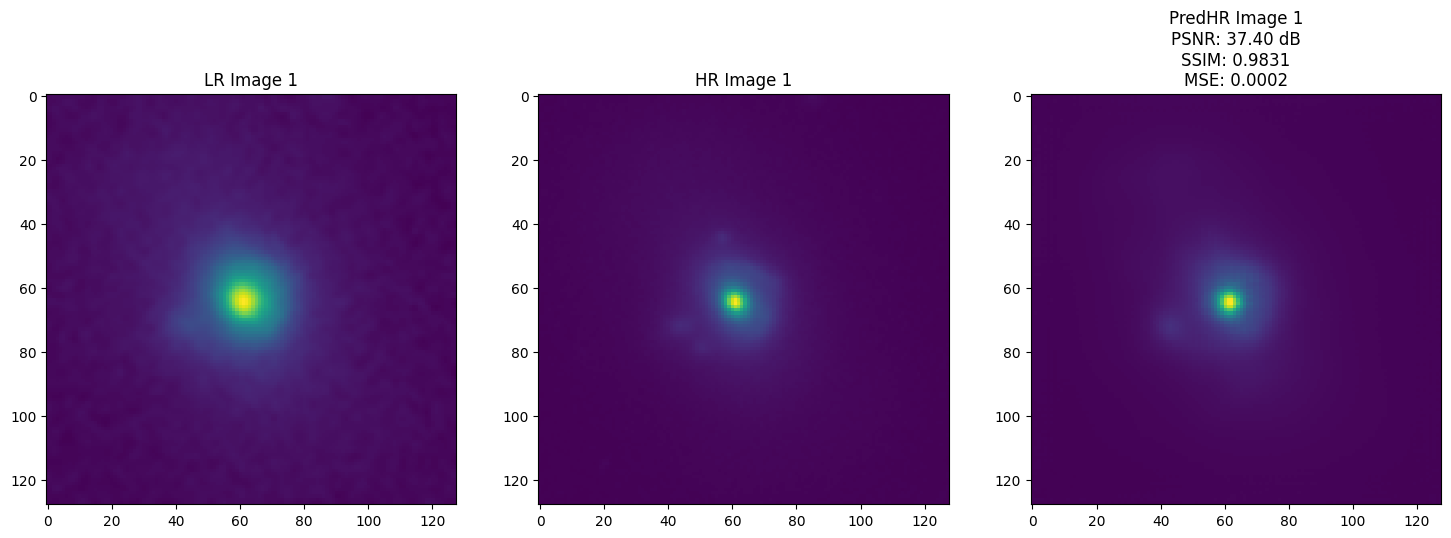

Image 1 - PSNR: 37.40 dB, SSIM: 0.9831, MSE: 0.0002


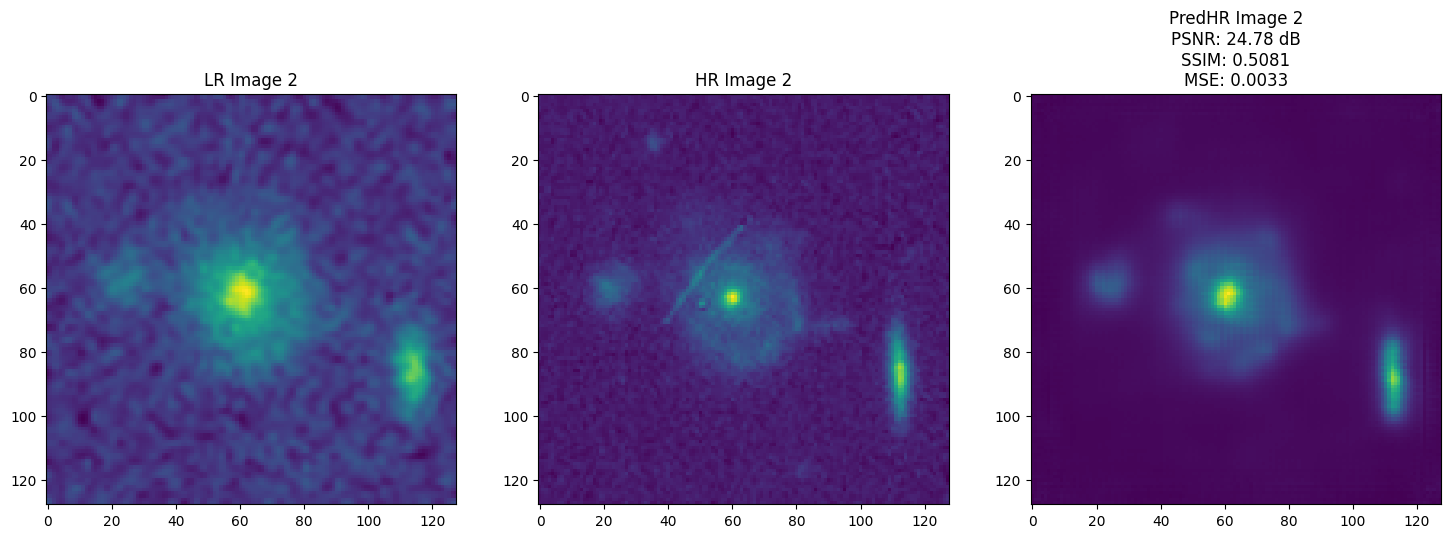

Image 2 - PSNR: 24.78 dB, SSIM: 0.5081, MSE: 0.0033


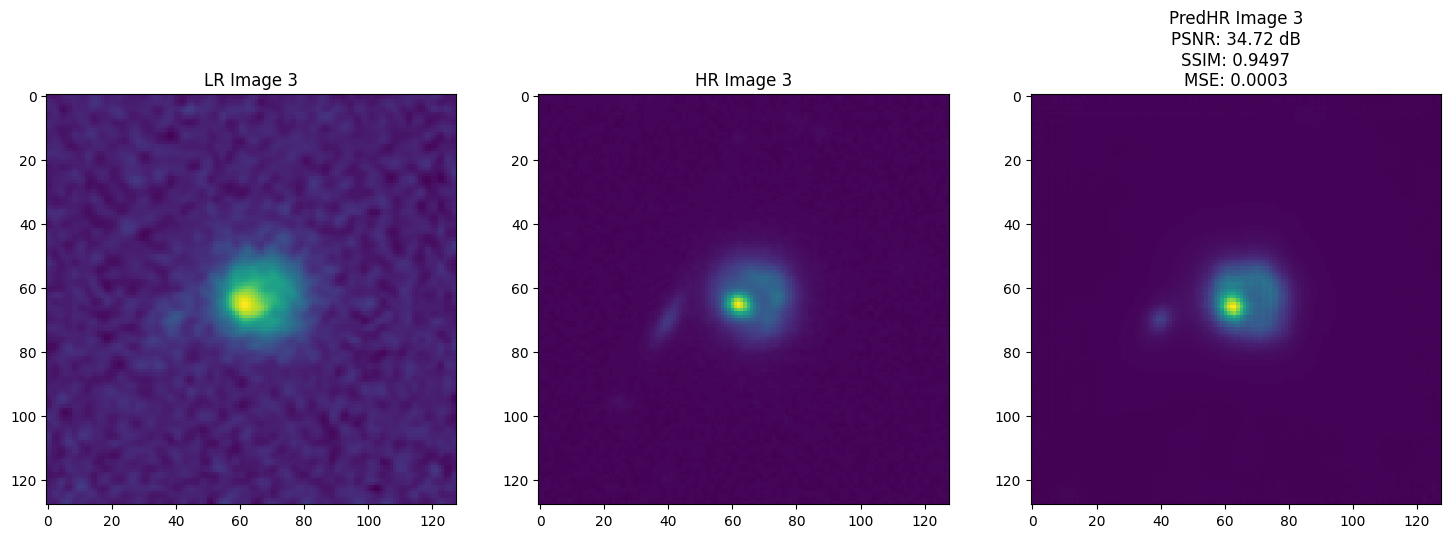

Image 3 - PSNR: 34.72 dB, SSIM: 0.9497, MSE: 0.0003


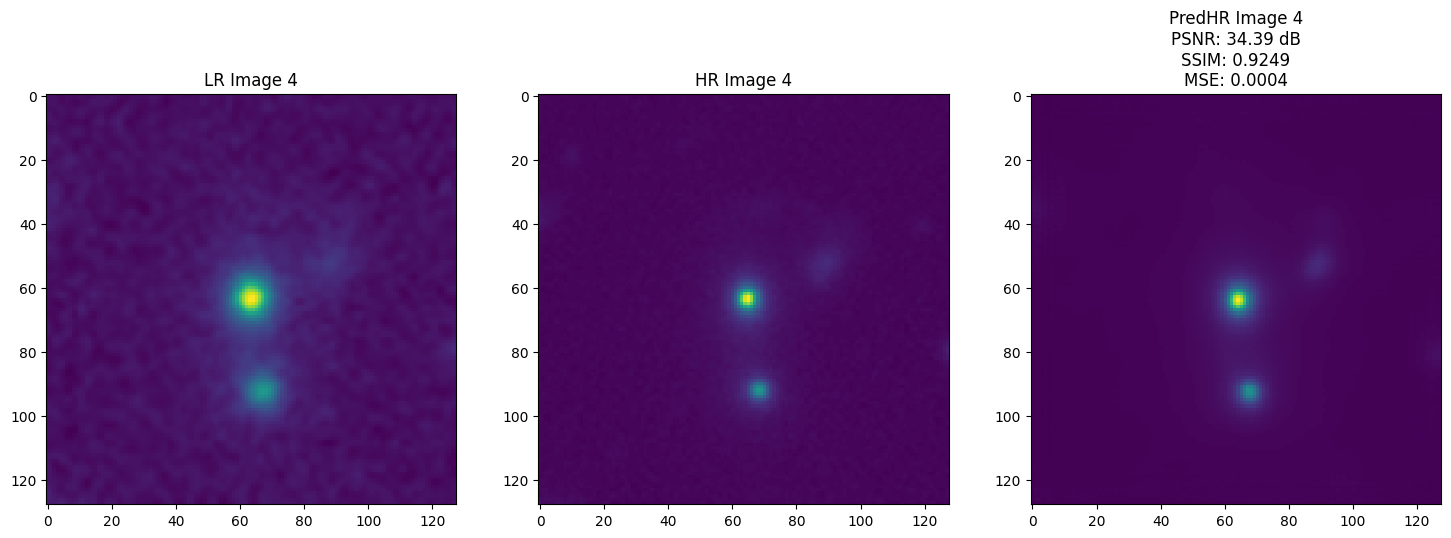

Image 4 - PSNR: 34.39 dB, SSIM: 0.9249, MSE: 0.0004


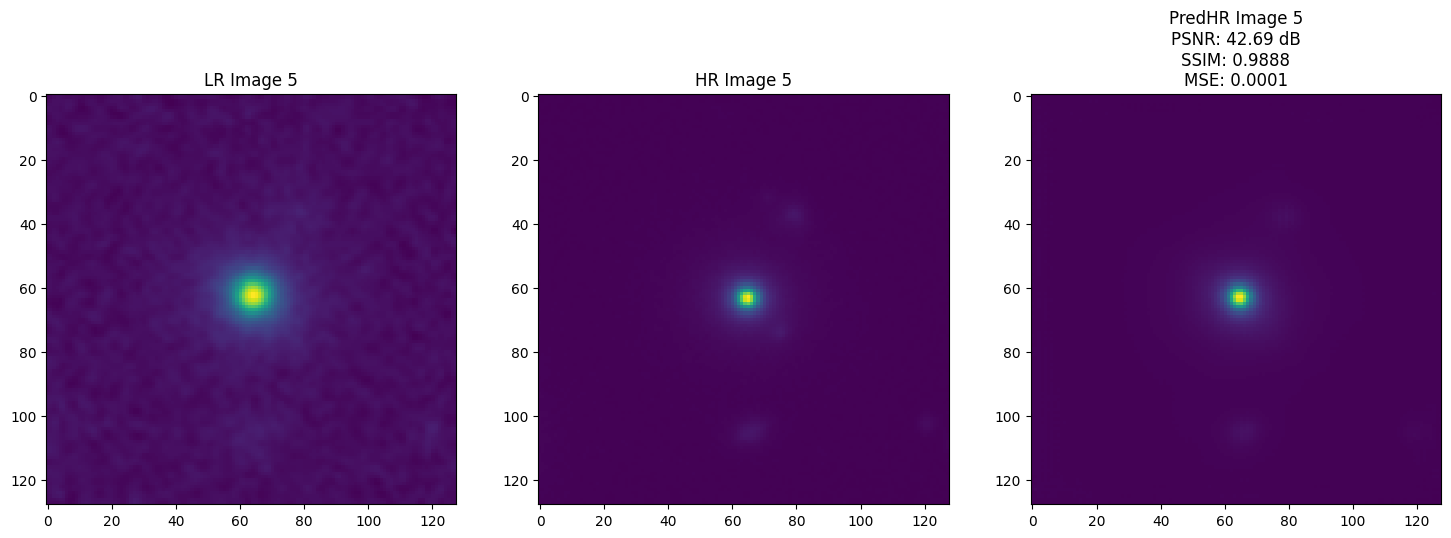

Image 5 - PSNR: 42.69 dB, SSIM: 0.9888, MSE: 0.0001


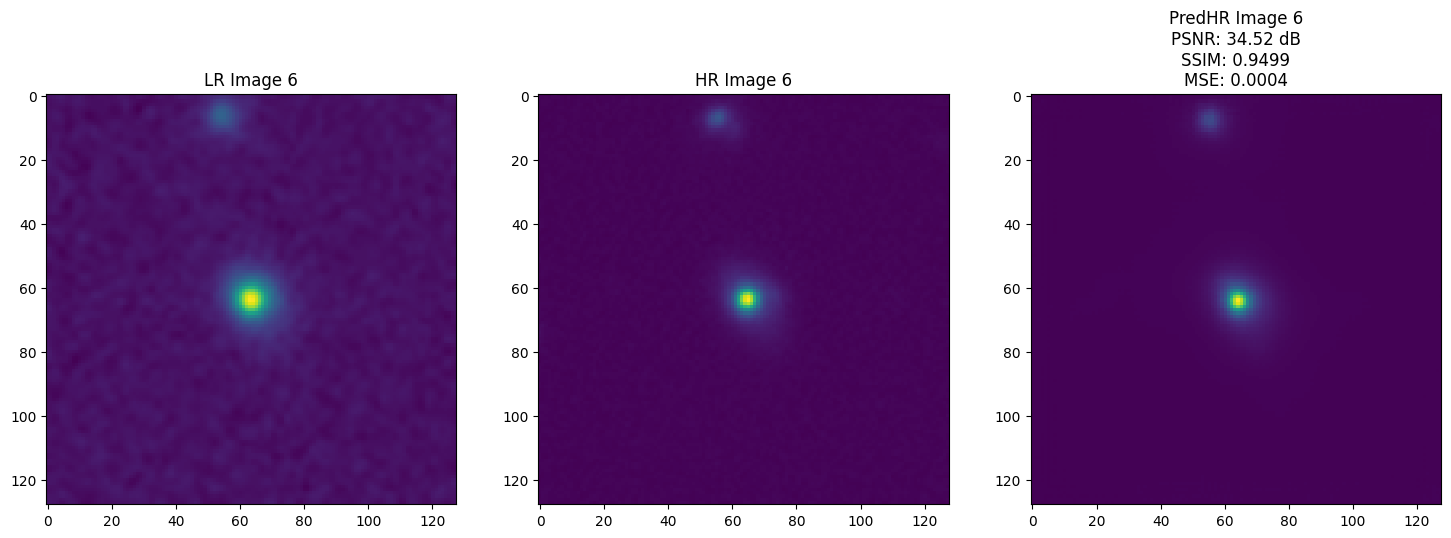

Image 6 - PSNR: 34.52 dB, SSIM: 0.9499, MSE: 0.0004


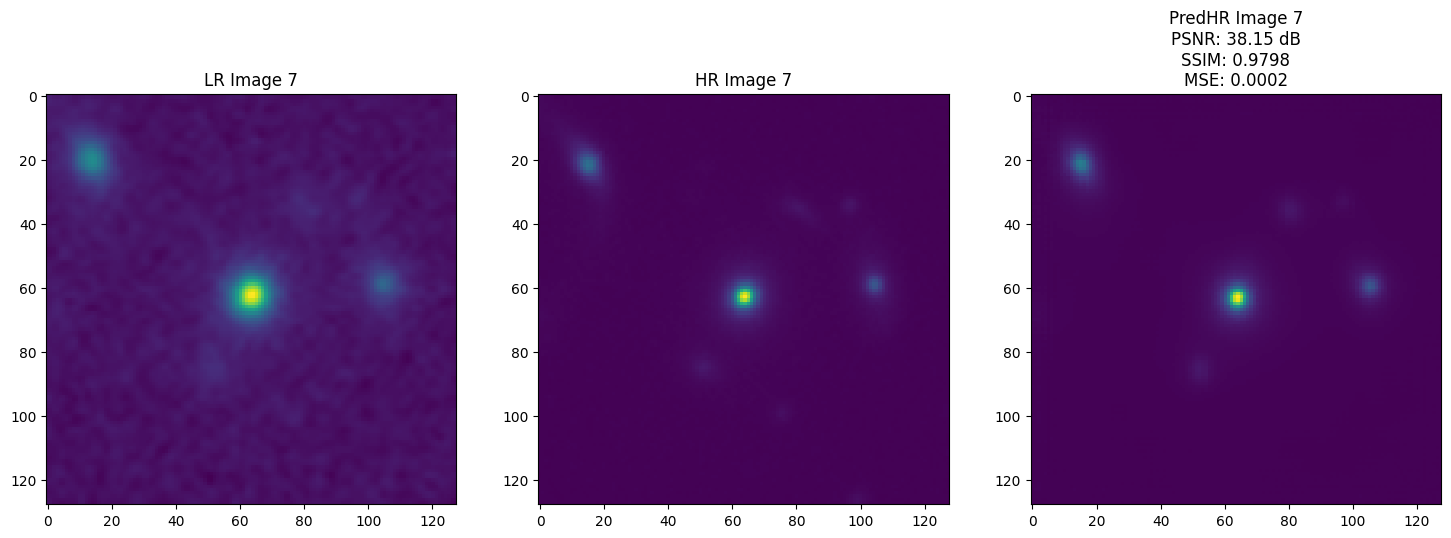

Image 7 - PSNR: 38.15 dB, SSIM: 0.9798, MSE: 0.0002


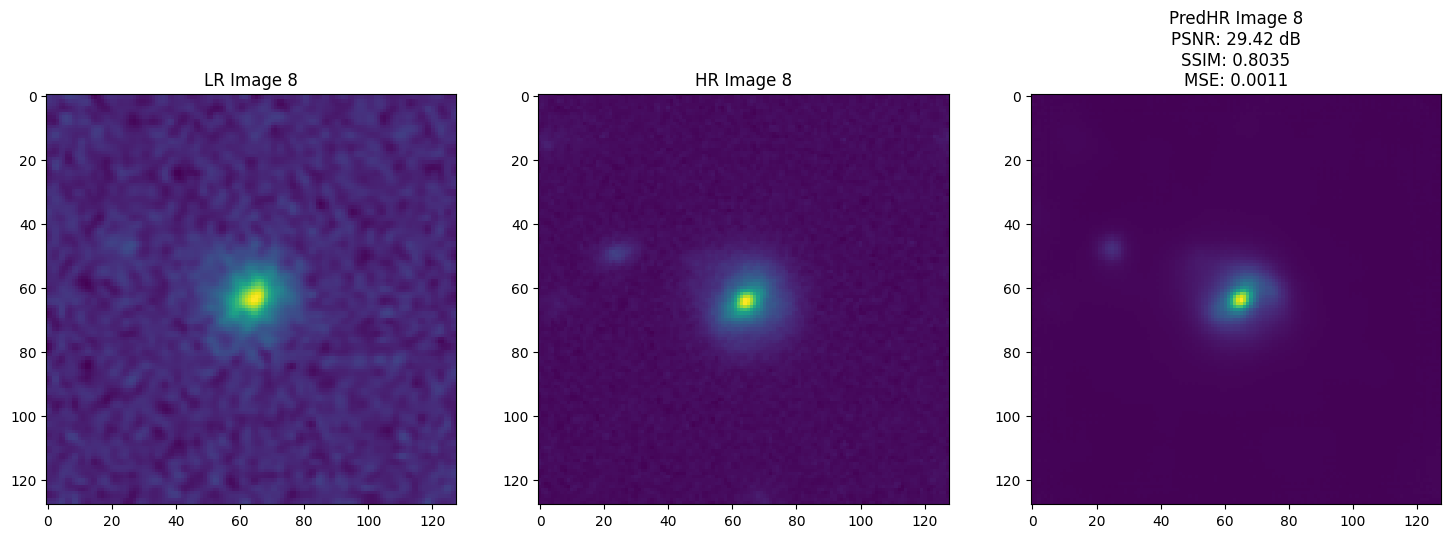

Image 8 - PSNR: 29.42 dB, SSIM: 0.8035, MSE: 0.0011


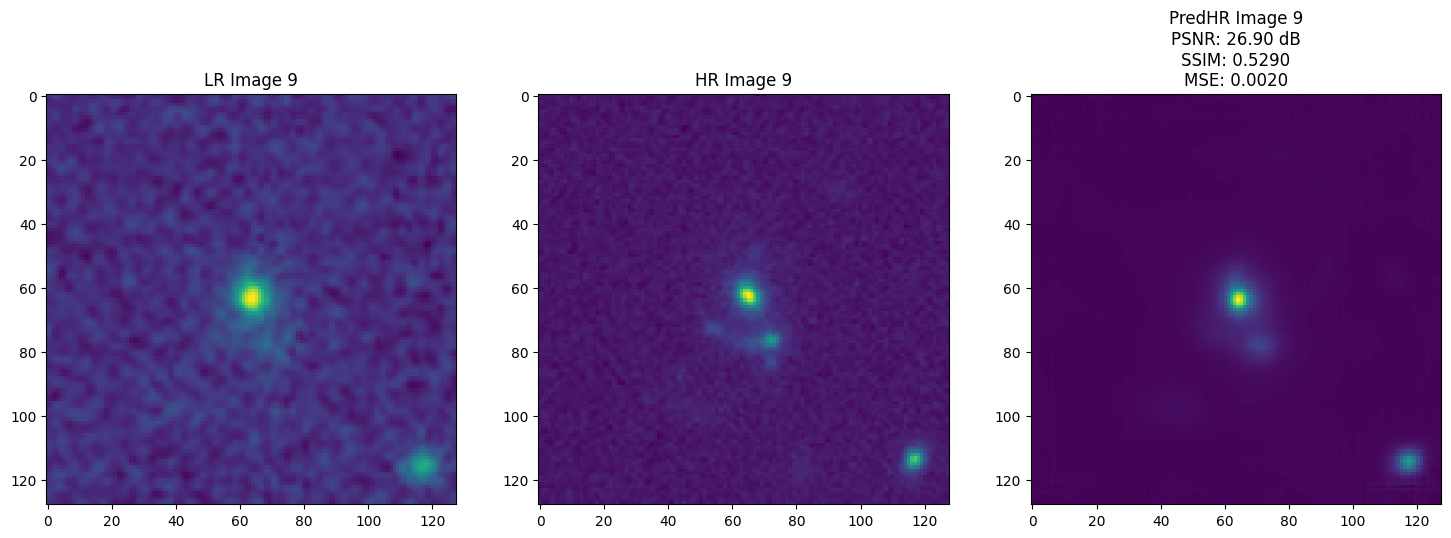

Image 9 - PSNR: 26.90 dB, SSIM: 0.5290, MSE: 0.0020


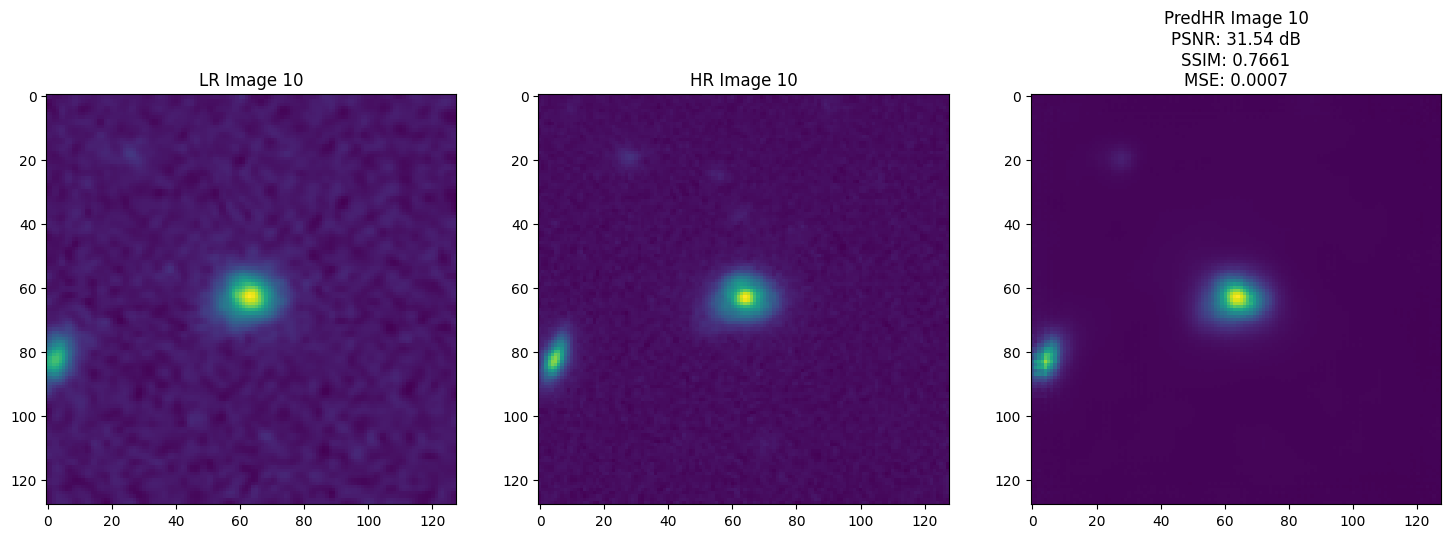

Image 10 - PSNR: 31.54 dB, SSIM: 0.7661, MSE: 0.0007


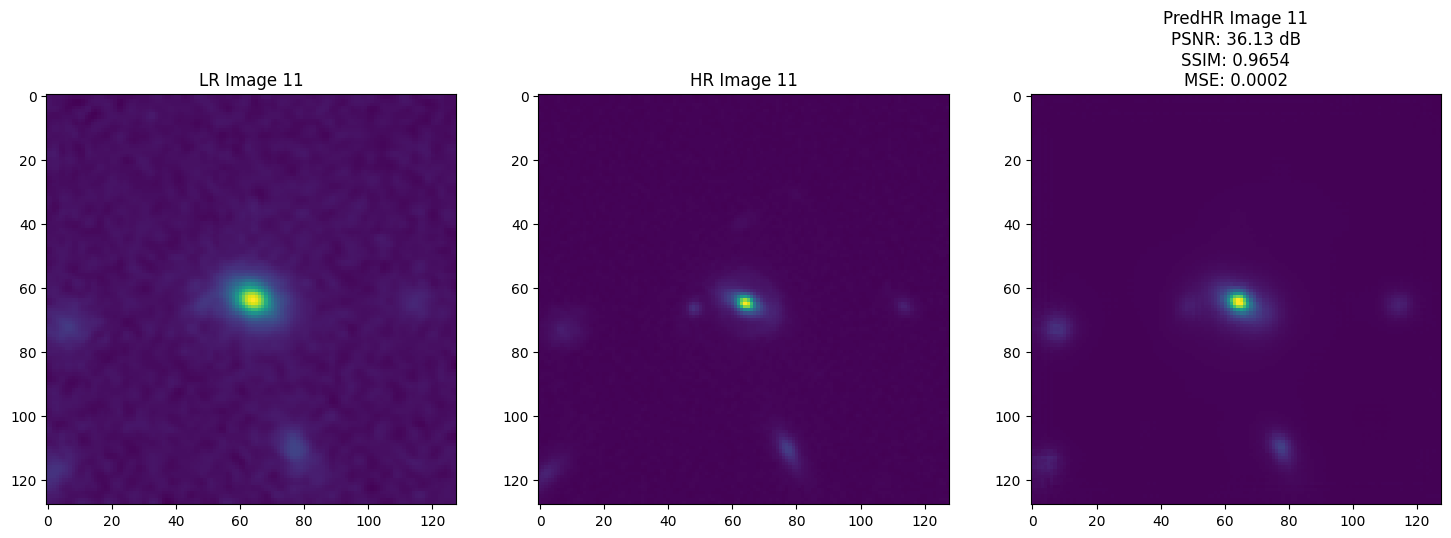

Image 11 - PSNR: 36.13 dB, SSIM: 0.9654, MSE: 0.0002


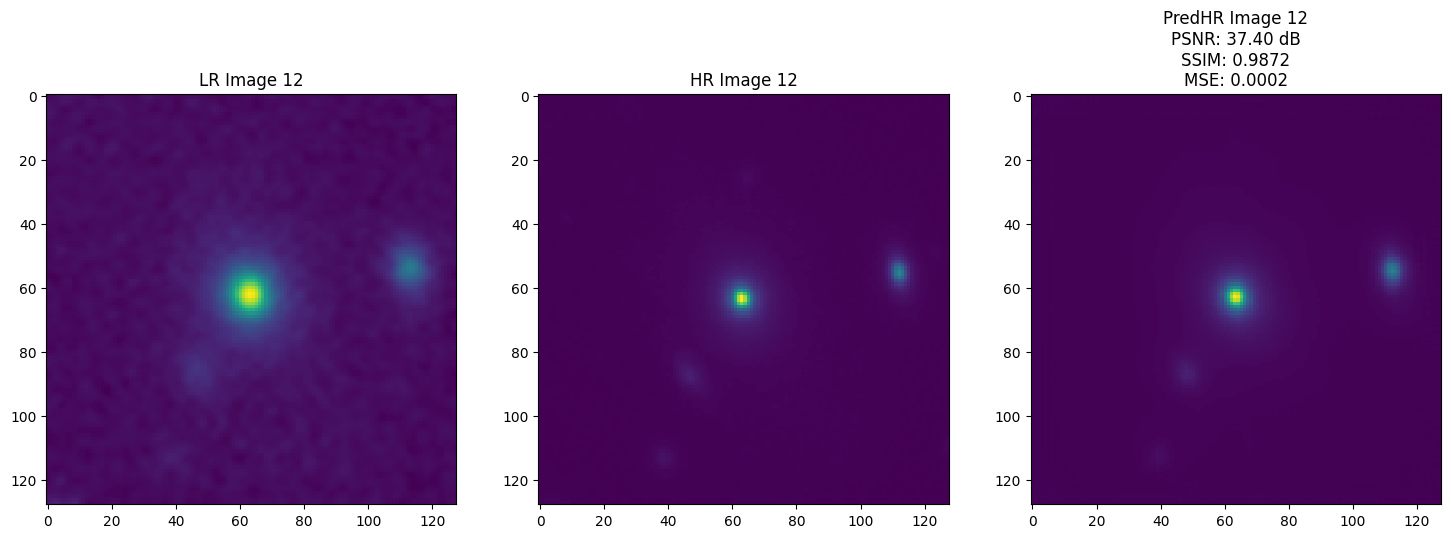

Image 12 - PSNR: 37.40 dB, SSIM: 0.9872, MSE: 0.0002


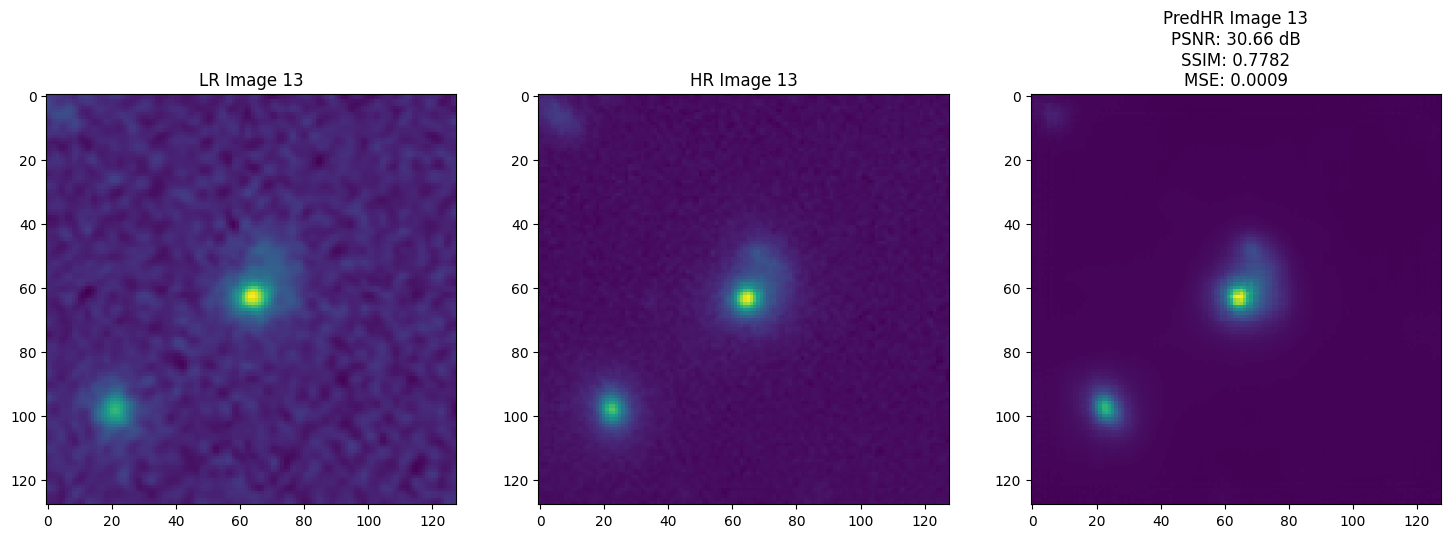

Image 13 - PSNR: 30.66 dB, SSIM: 0.7782, MSE: 0.0009


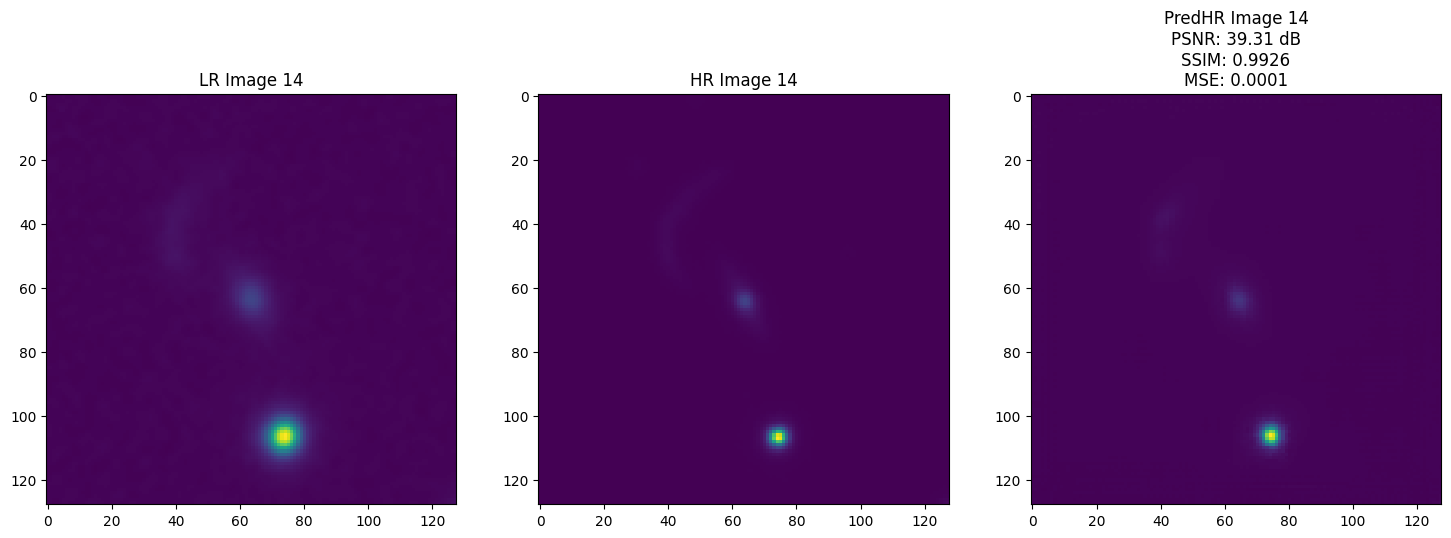

Image 14 - PSNR: 39.31 dB, SSIM: 0.9926, MSE: 0.0001


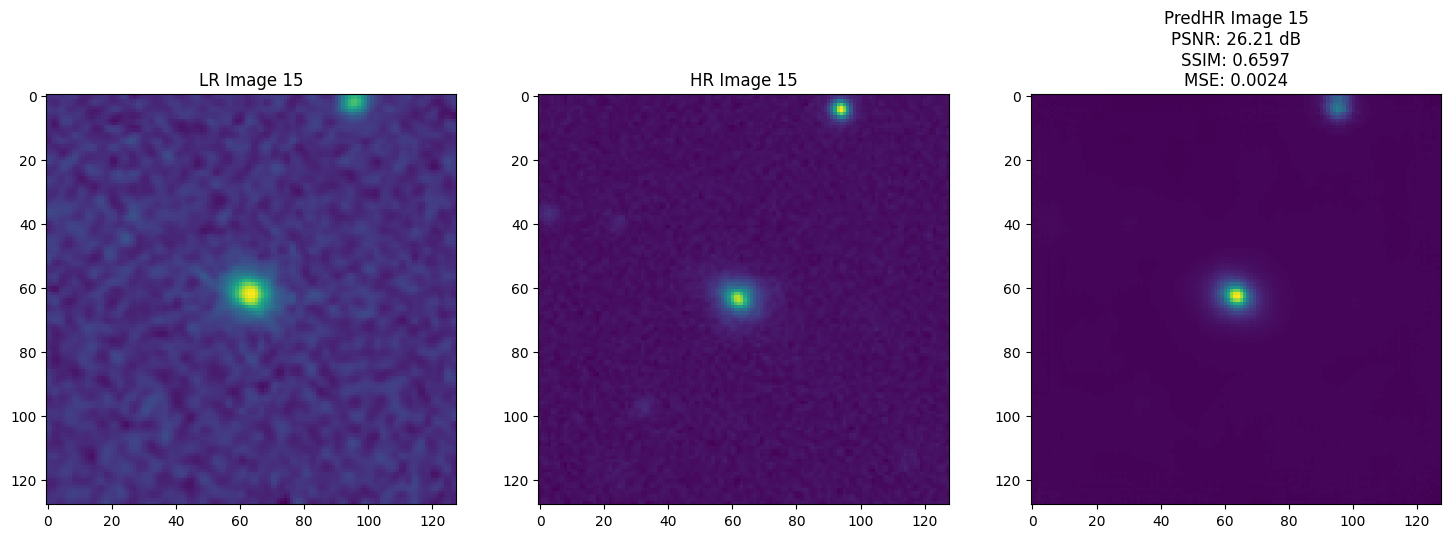

Image 15 - PSNR: 26.21 dB, SSIM: 0.6597, MSE: 0.0024


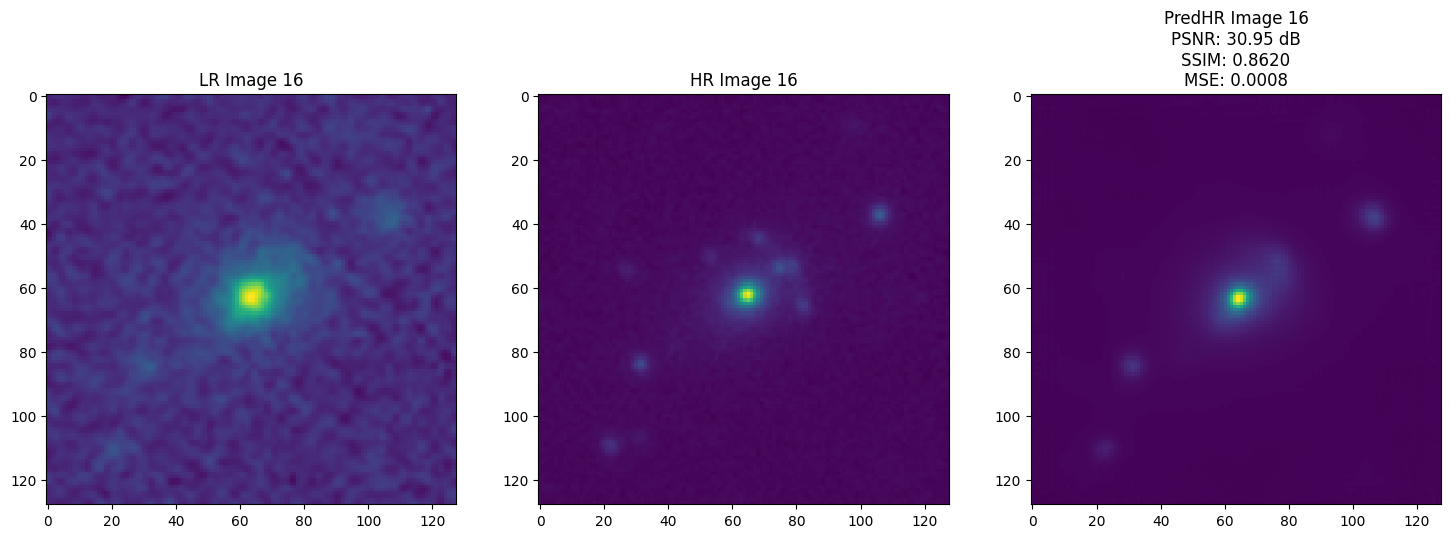

Image 16 - PSNR: 30.95 dB, SSIM: 0.8620, MSE: 0.0008

Average Metrics for all evaluated images:
Avg MSE (HR, Predicted HR): 0.00082865
Avg PSNR (HR, Predicted HR): 33.44735157
Avg SSIM (HR, Predicted HR): 0.85175533


In [68]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def display_images(lr, hr, pred_hr, idx, psnr, ssim, mse):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(lr, cmap='viridis')
    plt.title(f'LR Image {idx+1}')

    plt.subplot(1, 3, 2)
    plt.imshow(hr, cmap='viridis')
    plt.title(f'HR Image {idx+1}')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_hr, cmap='viridis')
    plt.title(f'PredHR Image {idx+1}\nPSNR: {psnr:.2f} dB\nSSIM: {ssim:.4f}\nMSE: {mse:.4f}')

    plt.show()

def evaluate_model(model, dataloader, num_batches=2, win_size=11, data_range=1.0):
    model.eval()
    mse_hr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, (lr_batch, hr_batch) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
            batch_size = lr_batch.size(0)

            timesteps = torch.randint(0, T, (batch_size,), device=device).long()
            noisy_images, _ = forward_diffusion_sample(hr_batch, timesteps, device=device)
            pred_hr_batch = model(noisy_images, lr_batch, timesteps)

            lr_batch = lr_batch.cpu().detach()
            hr_batch = hr_batch.cpu().detach()
            pred_hr_batch = pred_hr_batch.cpu().detach()

            for i in range(batch_size):  # Iterate through each image in the batch
                lr = lr_batch[i].squeeze()
                hr = hr_batch[i].squeeze()
                pred_hr = pred_hr_batch[i].squeeze()

                psnr = calculate_psnr(hr, pred_hr).item()
                ssim = calculate_ssim(hr, pred_hr, data_range, win_size)
                mse = nn.functional.mse_loss(hr, pred_hr).item()

                mse_hr_predhr += mse
                psnr_hr_predhr += psnr
                ssim_hr_predhr += ssim
                num_samples += 1

                if batch_idx < 2:  # Display only for the first 2 batches
                    display_images(lr, hr, pred_hr, batch_idx*batch_size + i, psnr, ssim, mse)

                print(f"Image {batch_idx*batch_size + i + 1} - PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}, MSE: {mse:.4f}")

    mse_hr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_hr_predhr /= num_samples

    print(f"\nAverage Metrics for all evaluated images:")
    print(f"Avg MSE (HR, Predicted HR): {mse_hr_predhr:.8f}")
    print(f"Avg PSNR (HR, Predicted HR): {psnr_hr_predhr:.8f}")
    print(f"Avg SSIM (HR, Predicted HR): {ssim_hr_predhr:.8f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

evaluate_model(unet_model, test_dataloader, num_batches=2)

# Visualize more Images

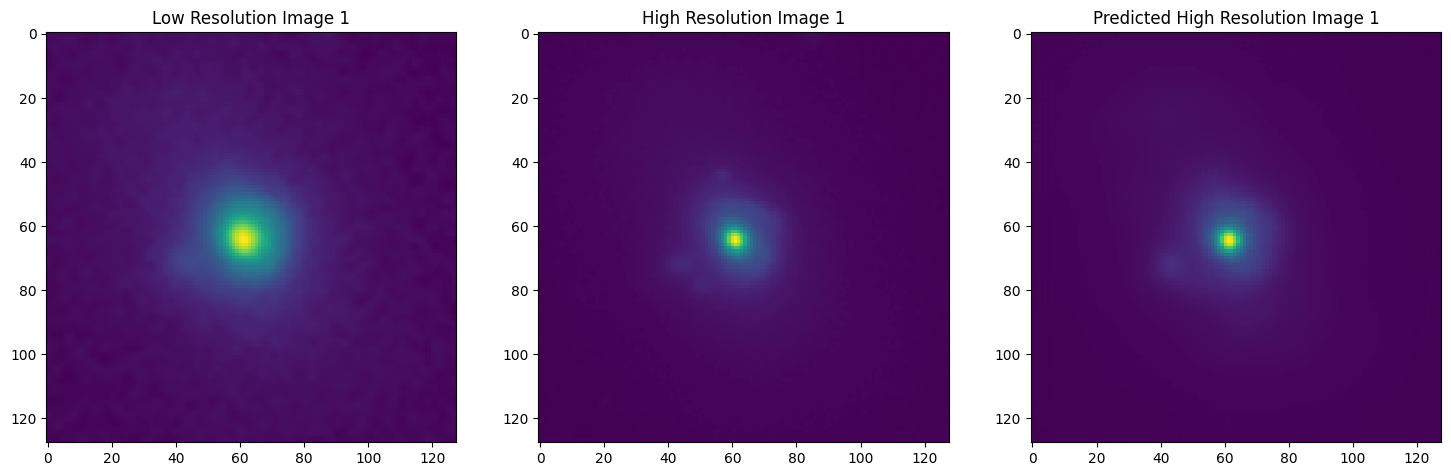

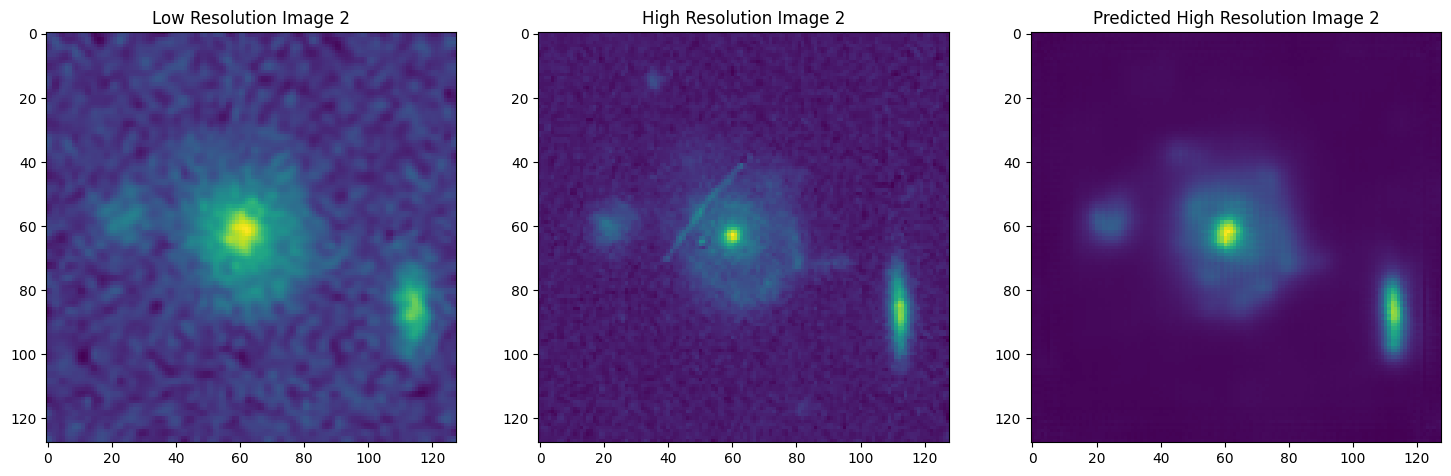

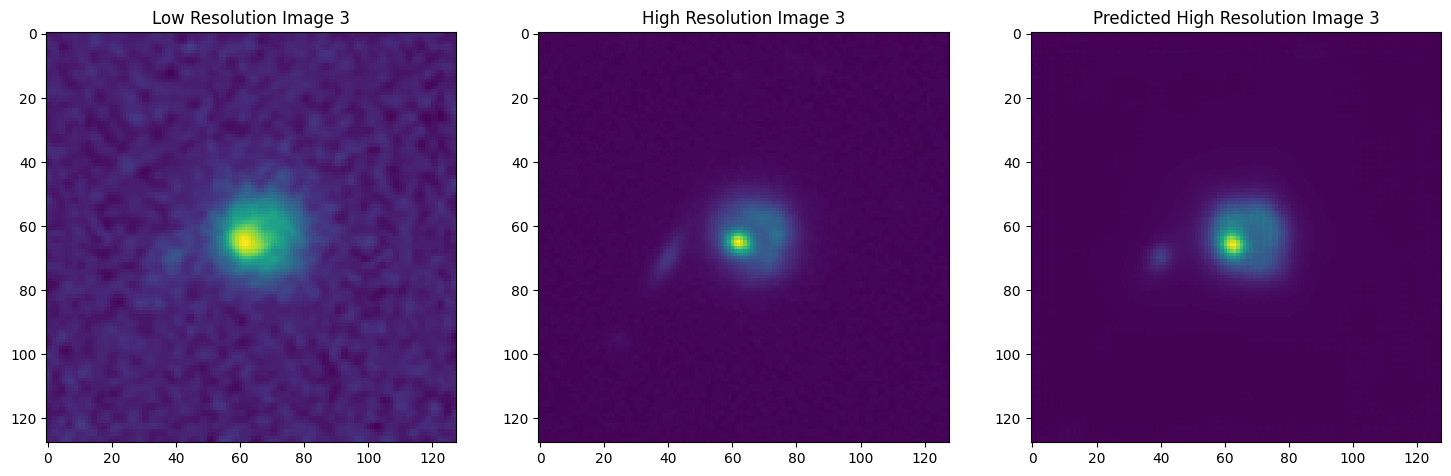

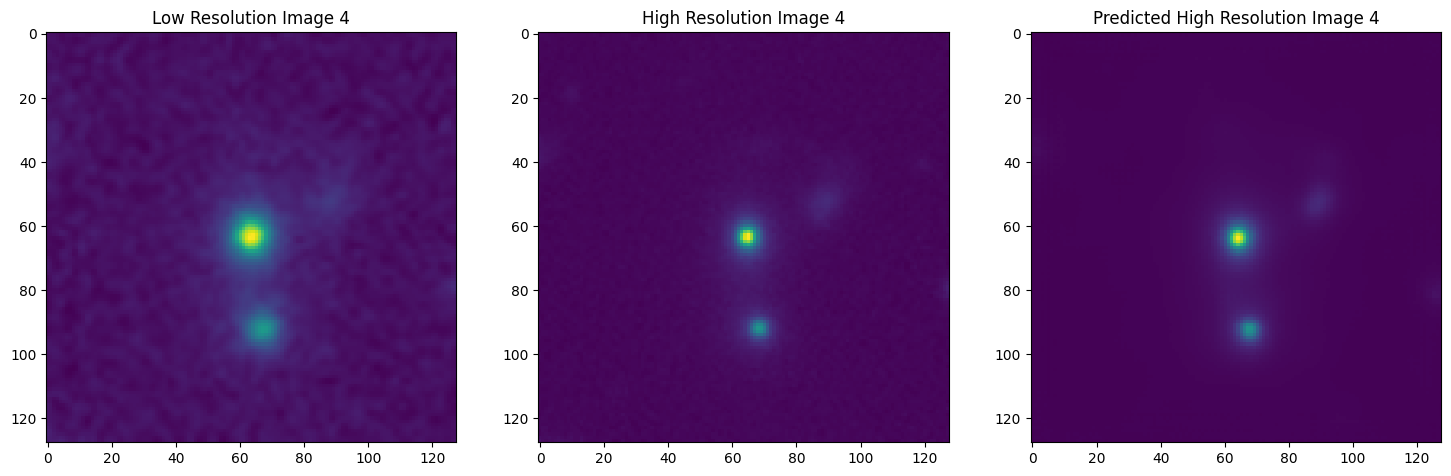

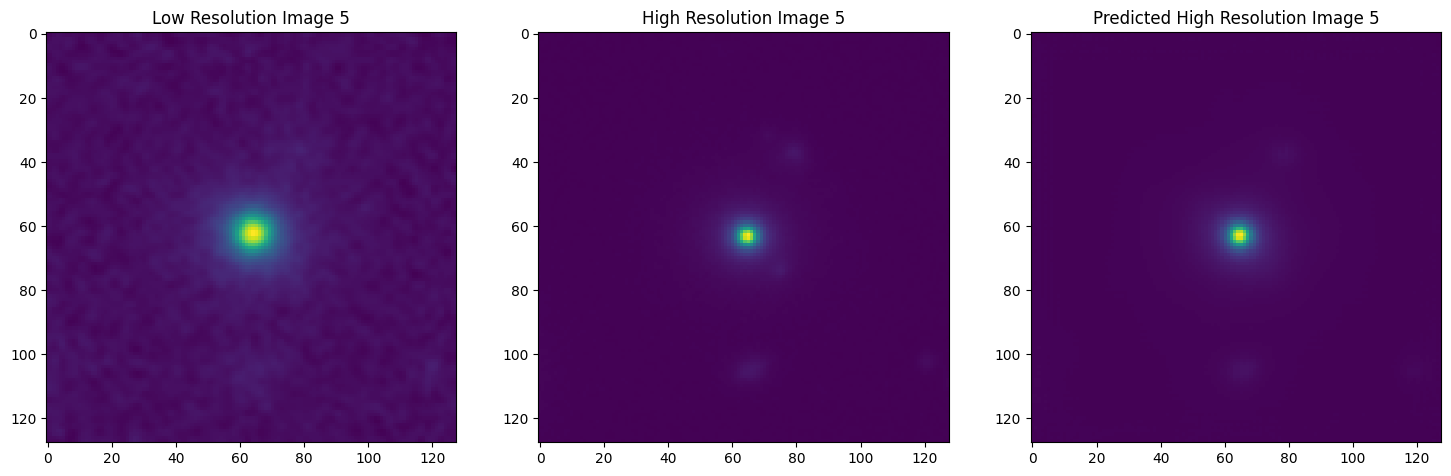

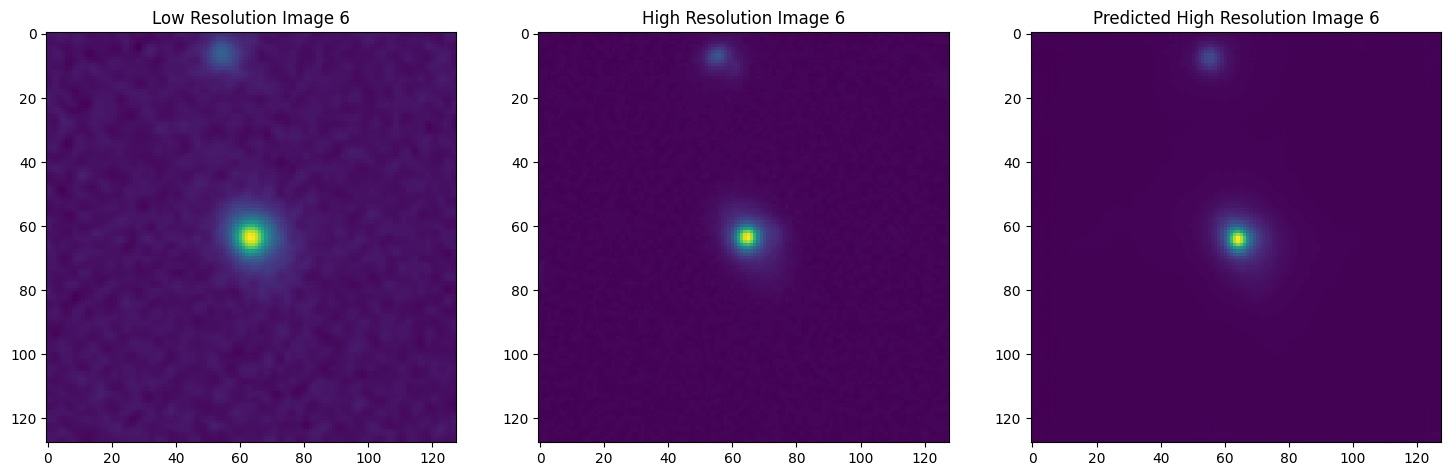

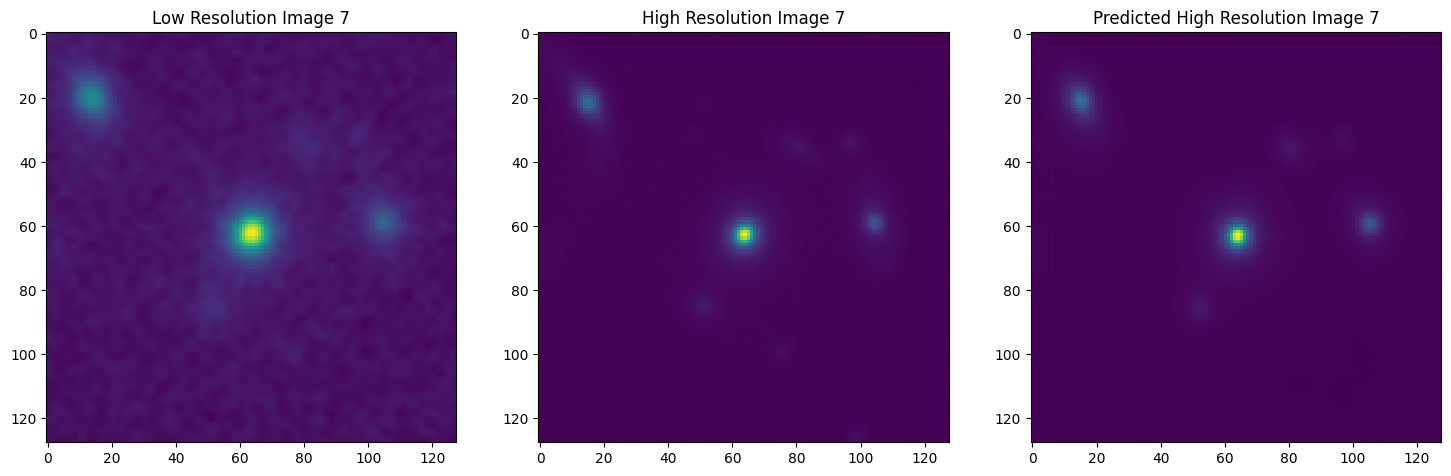

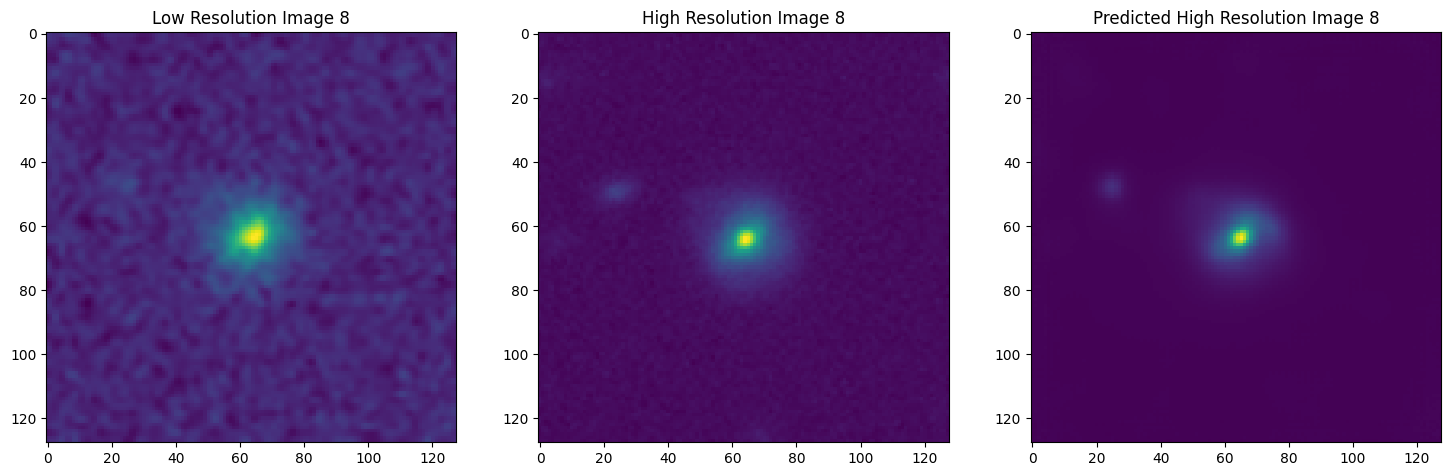

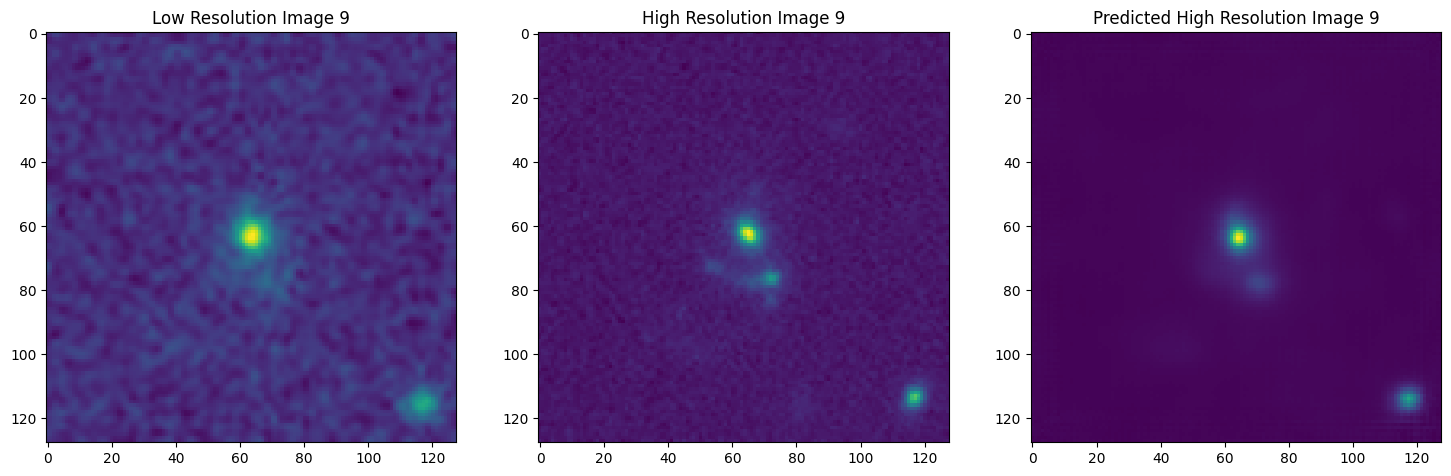

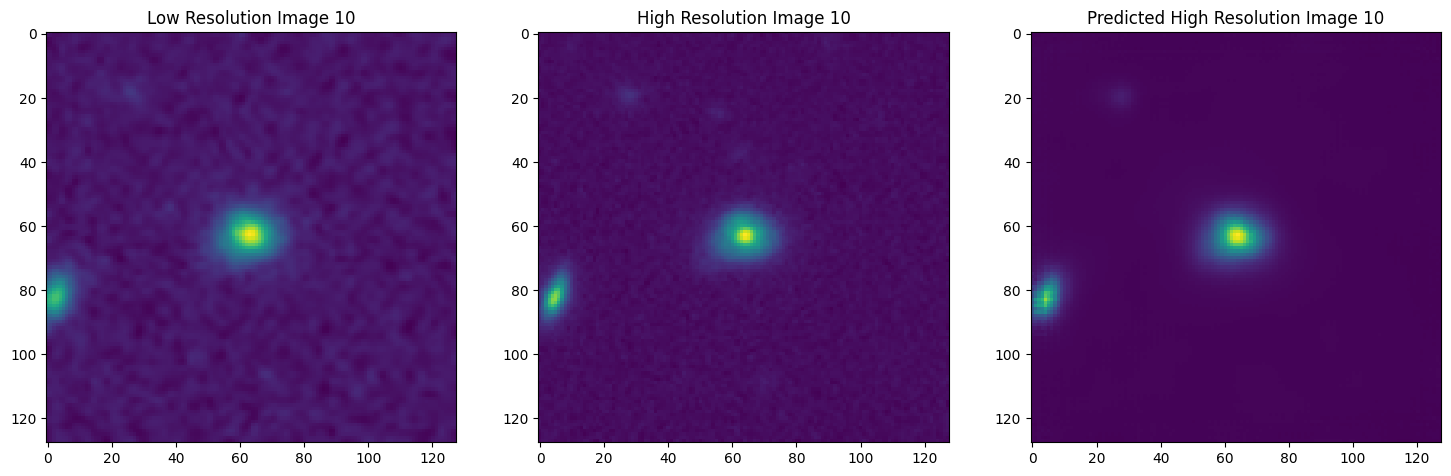

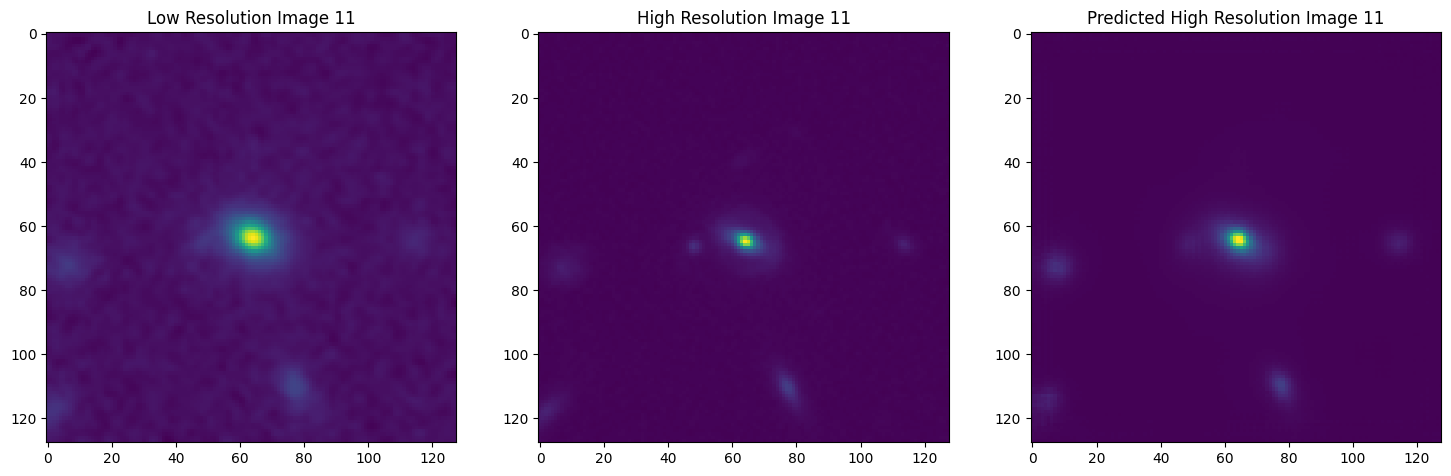

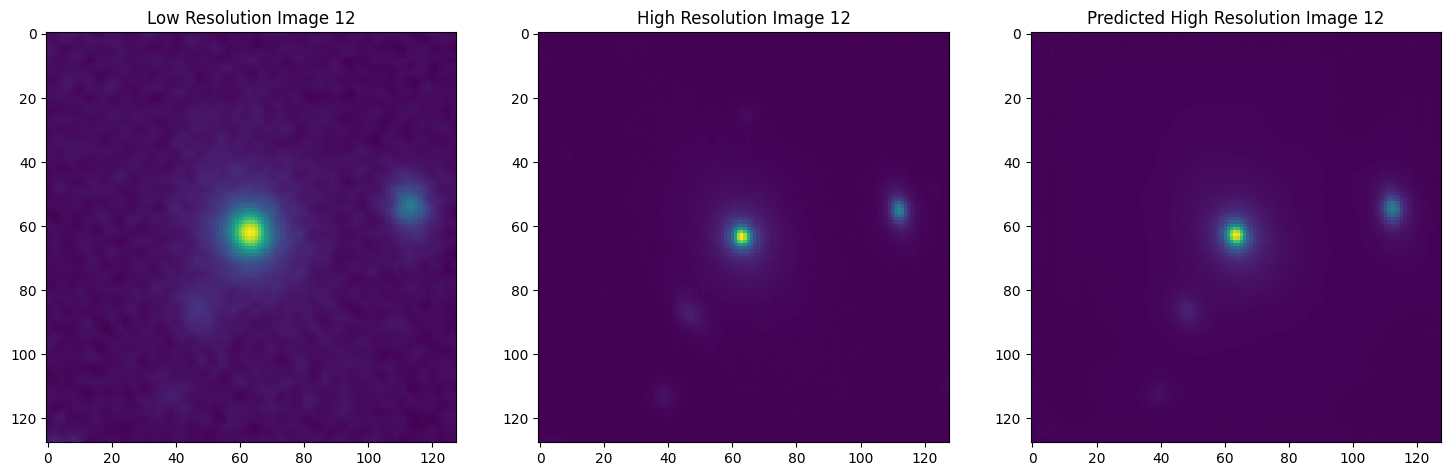

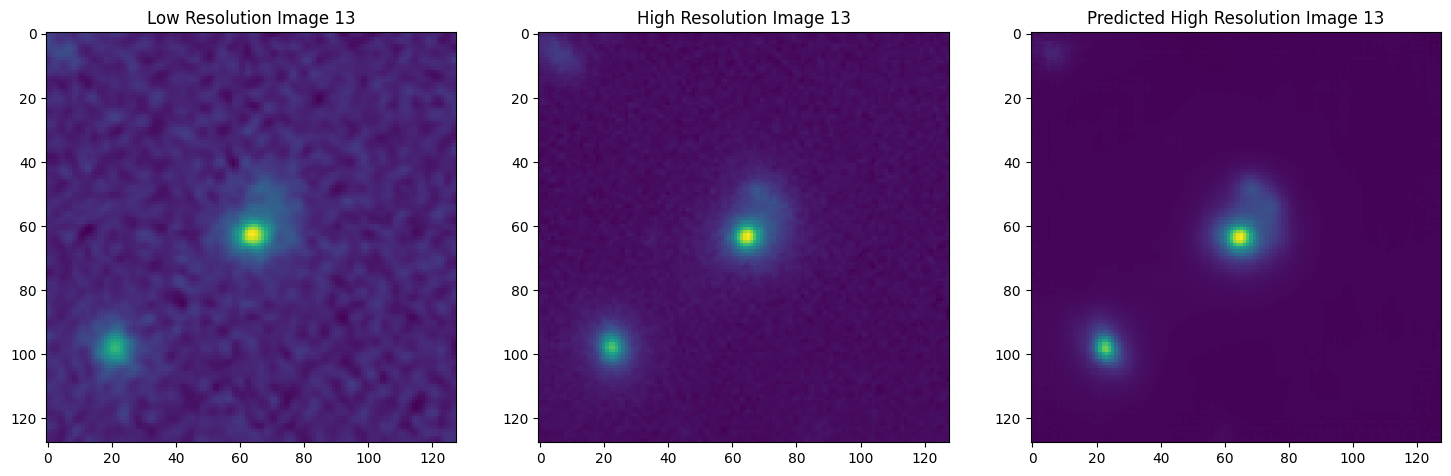

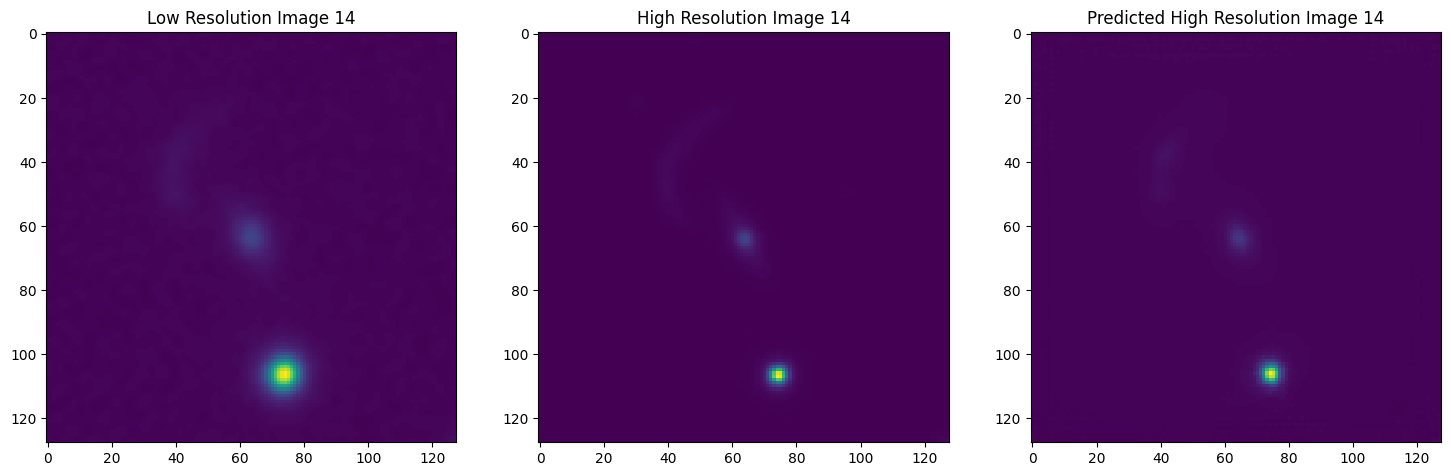

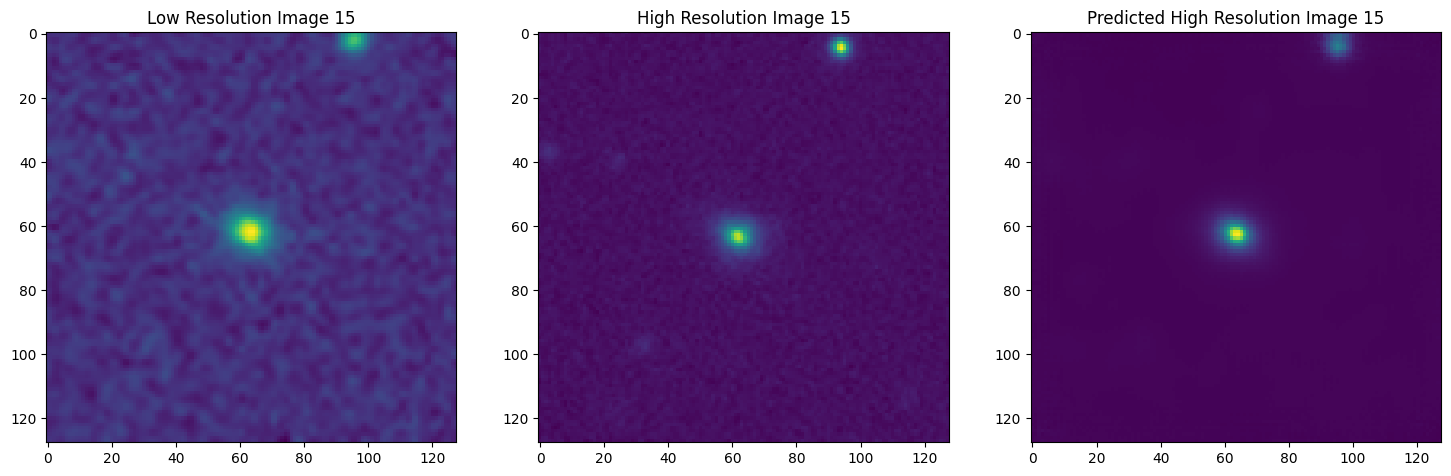

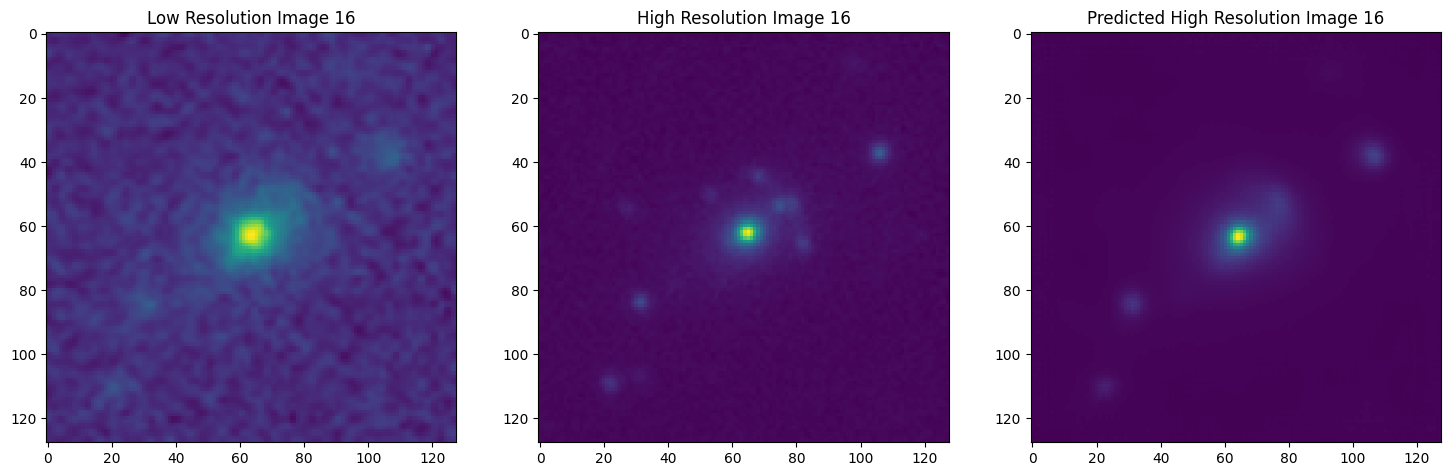

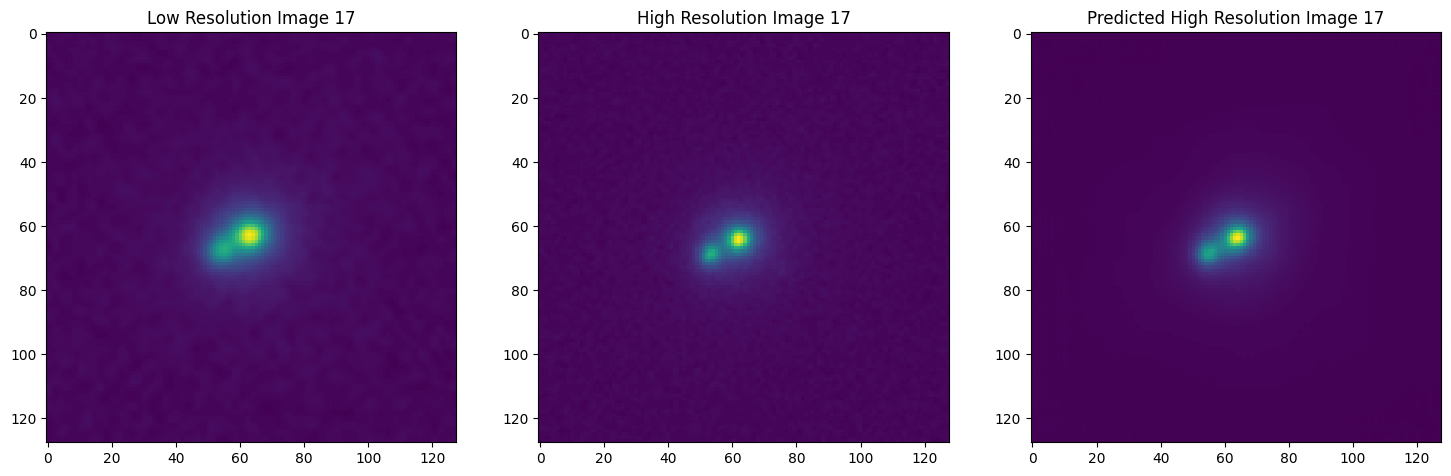

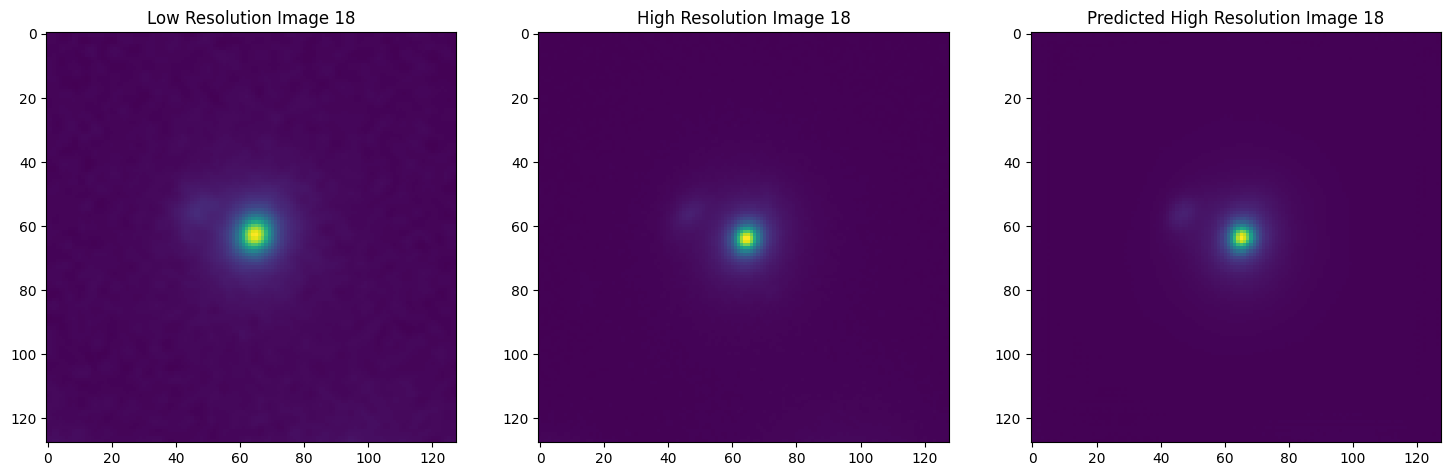

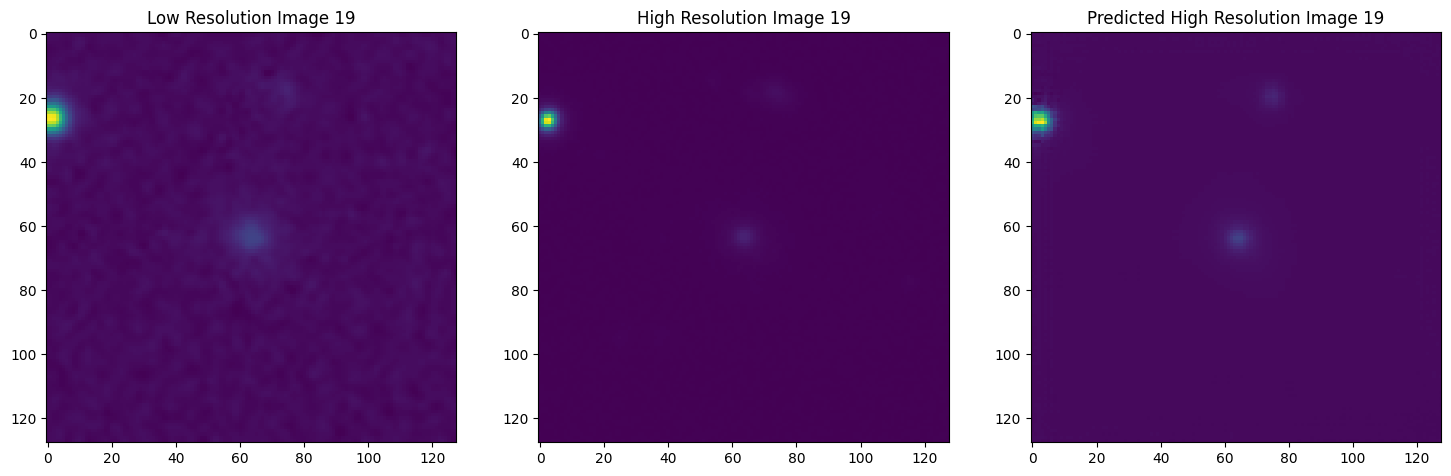

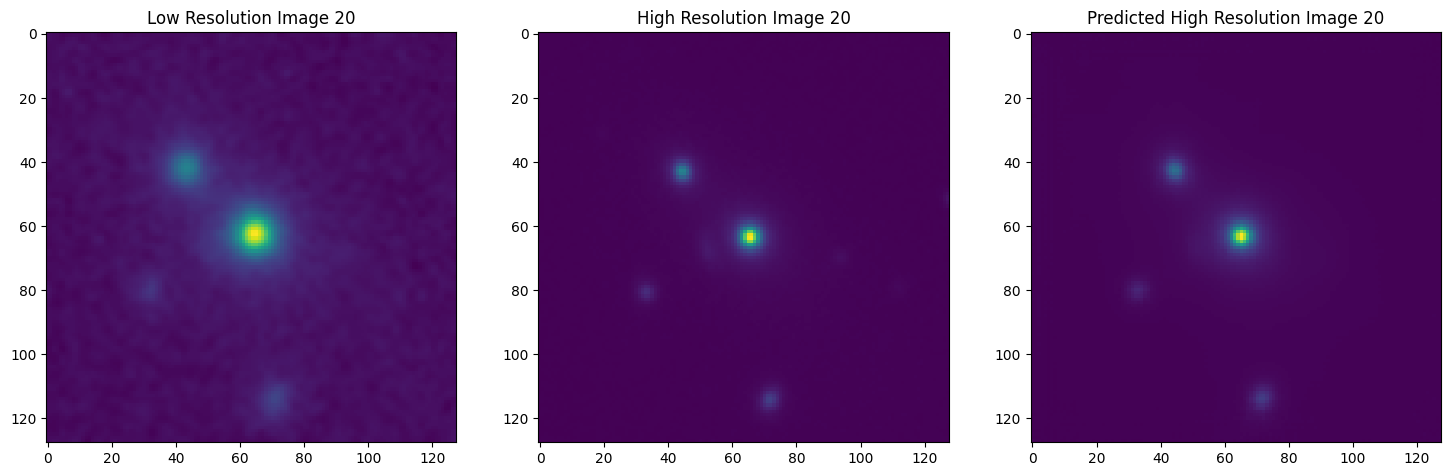

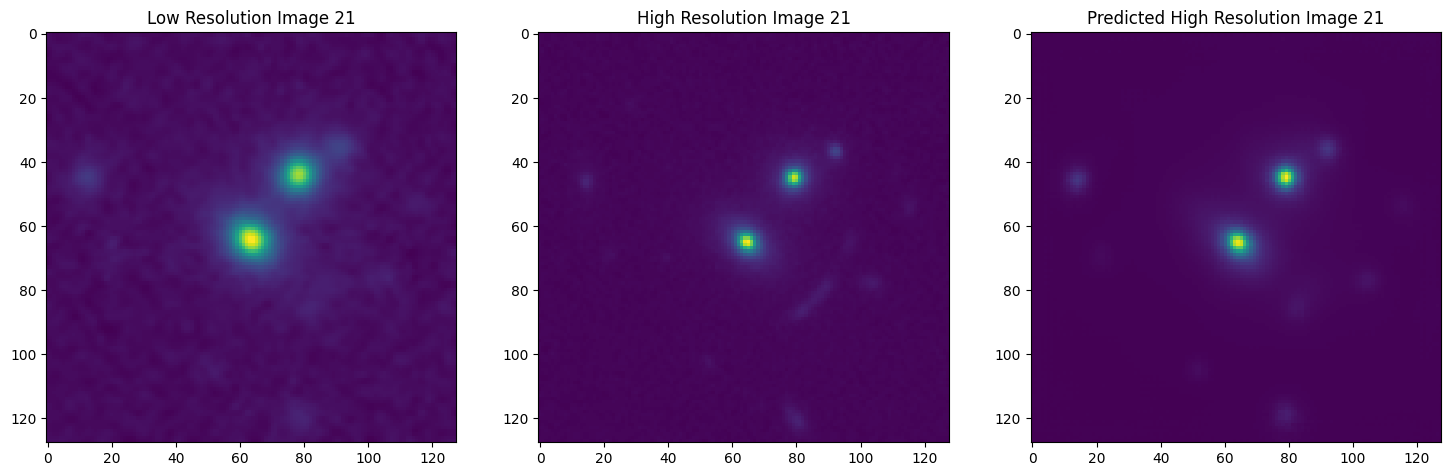

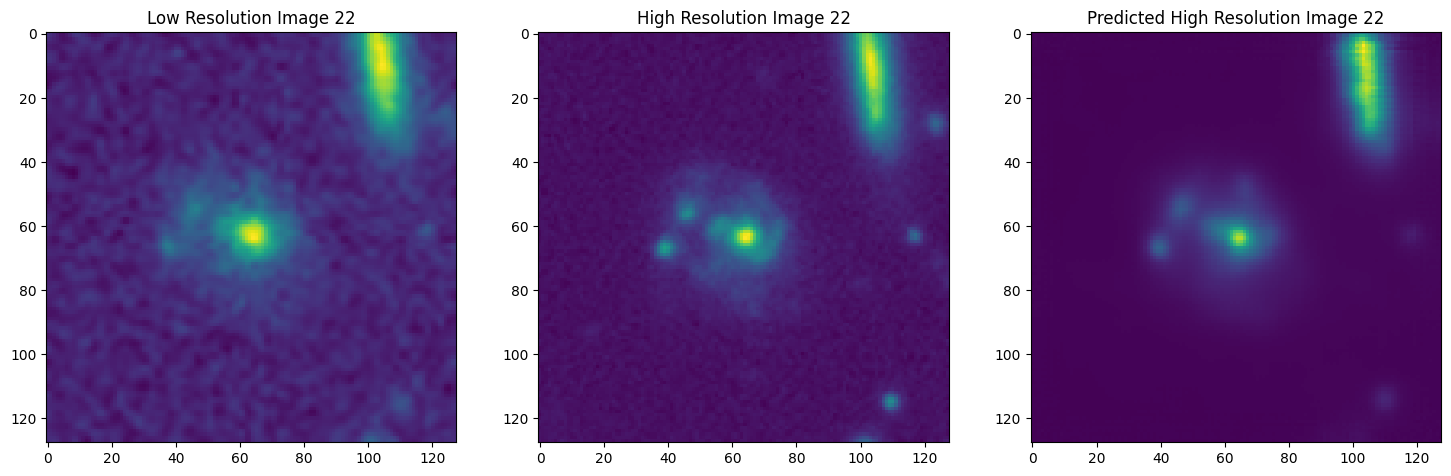

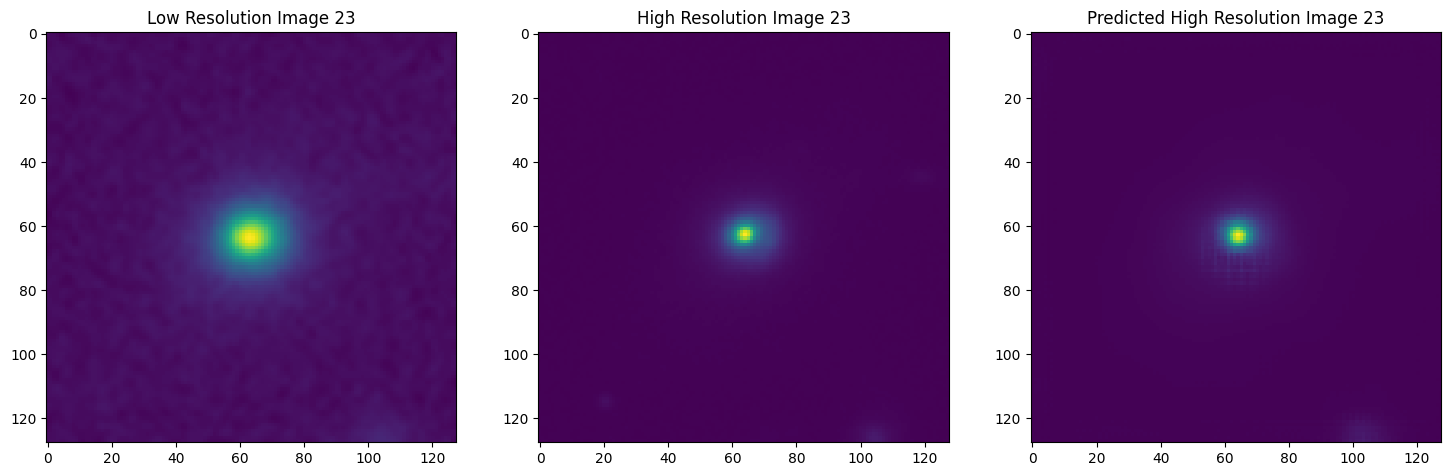

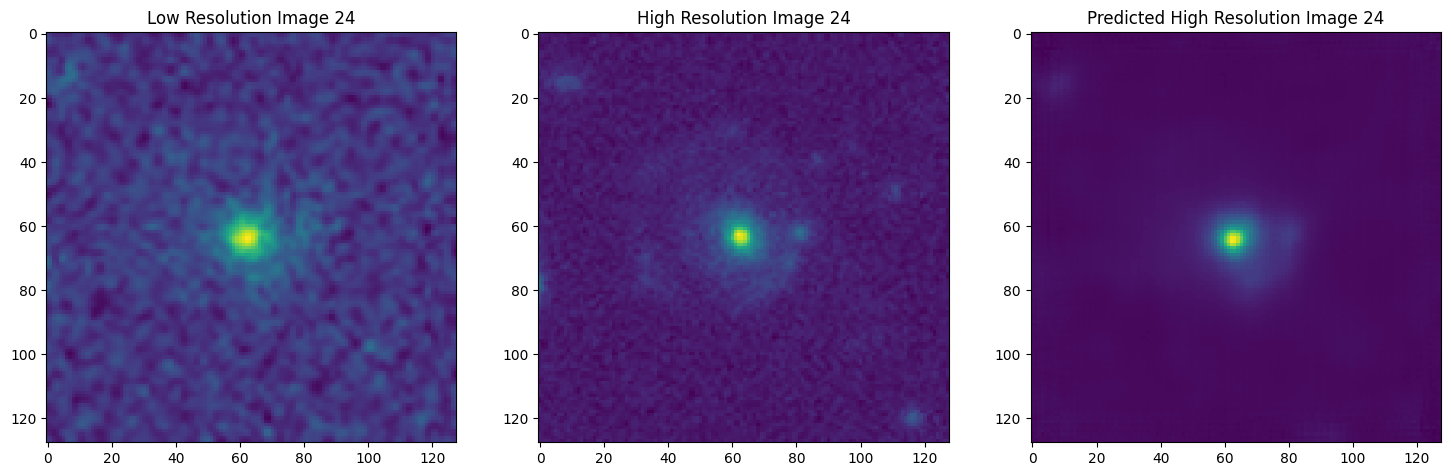

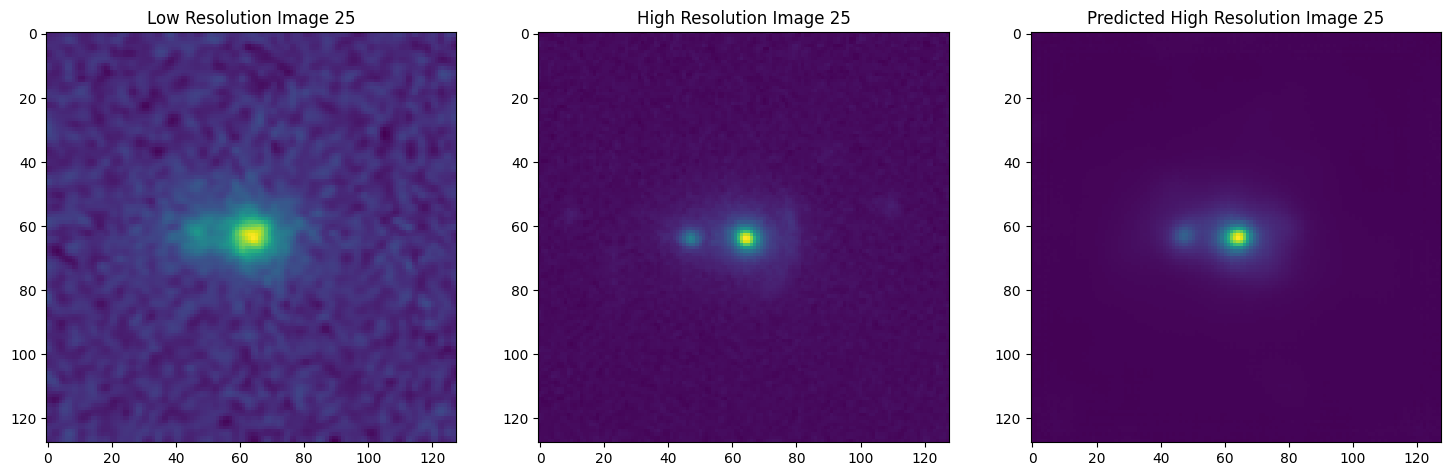

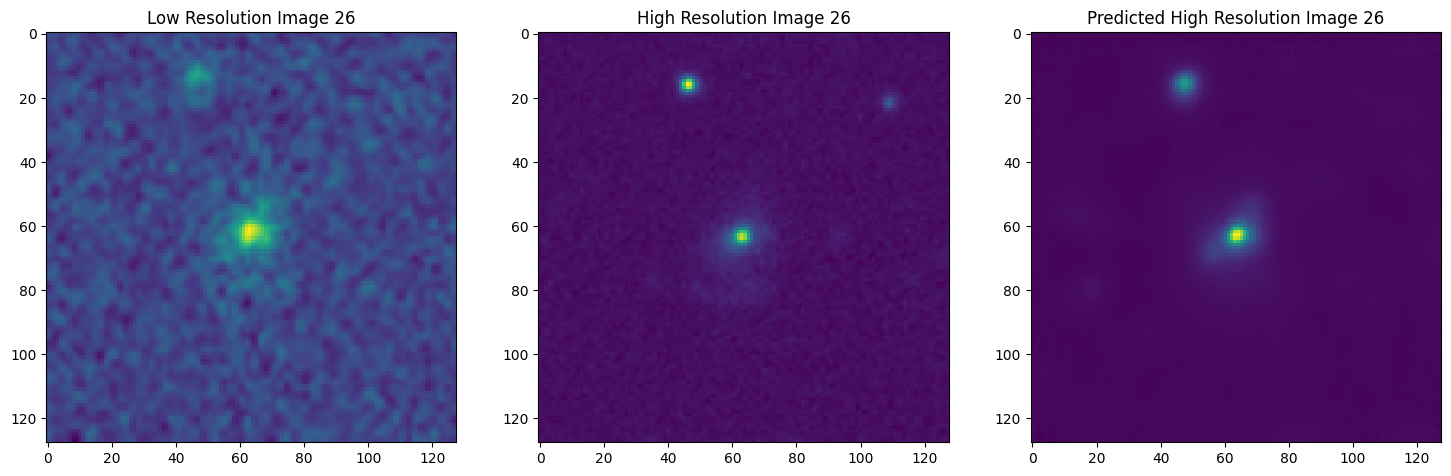

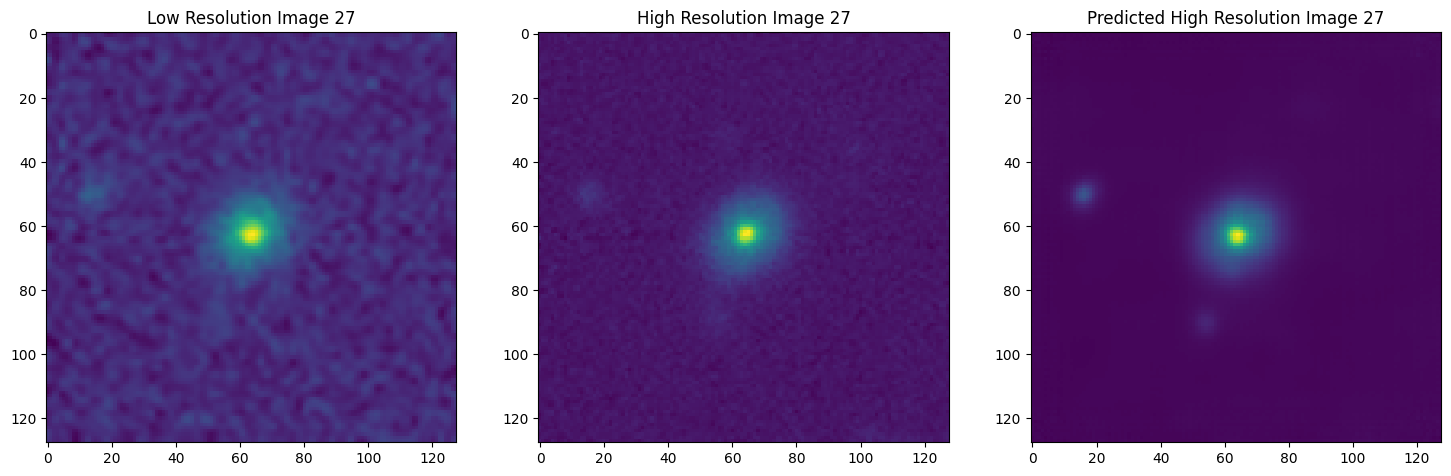

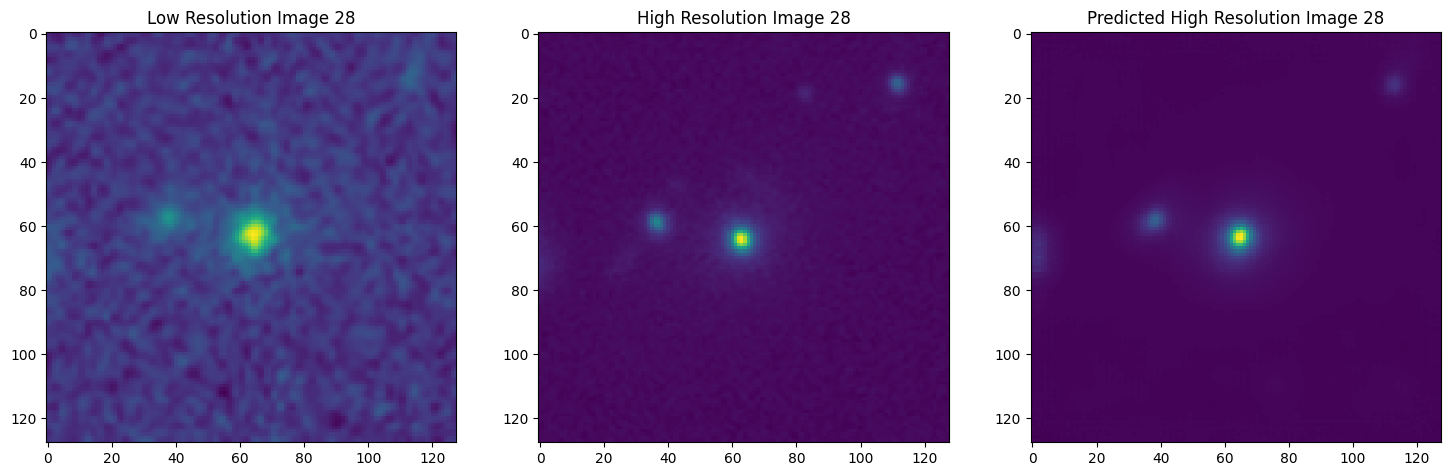

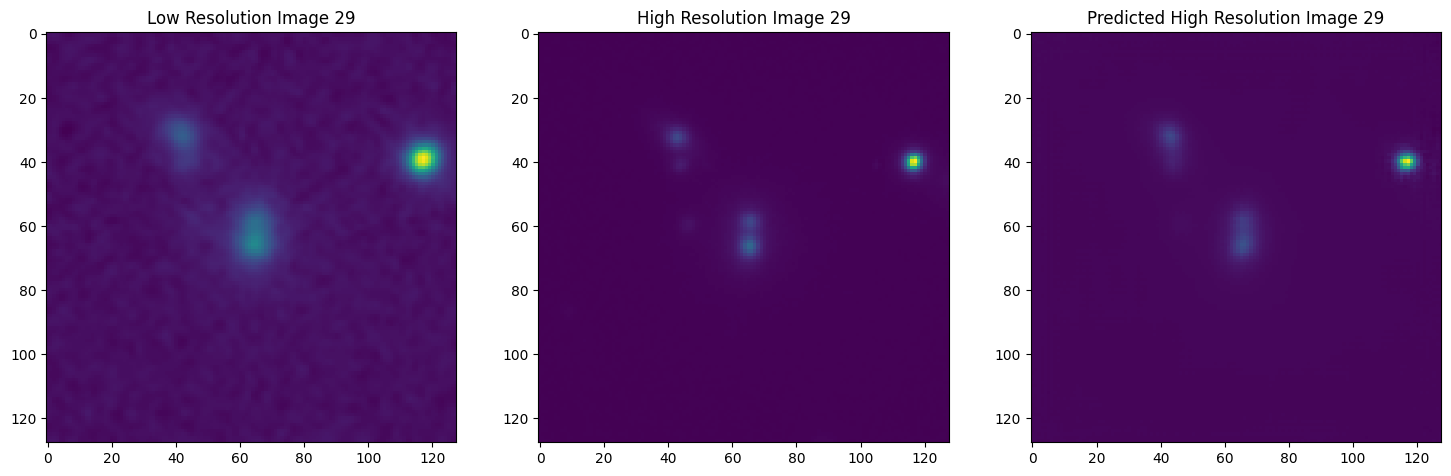

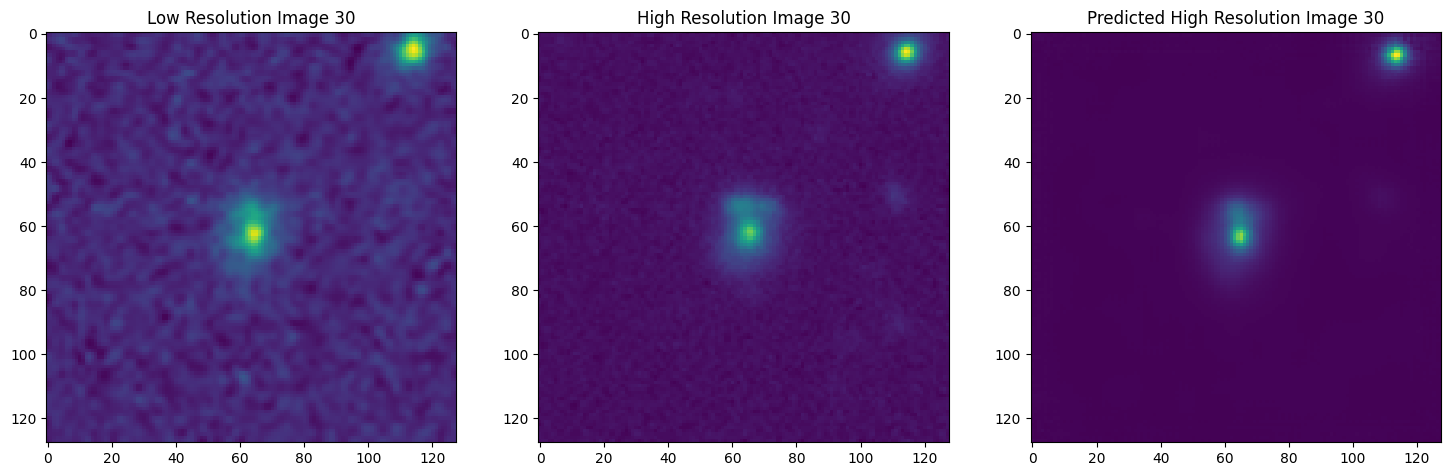

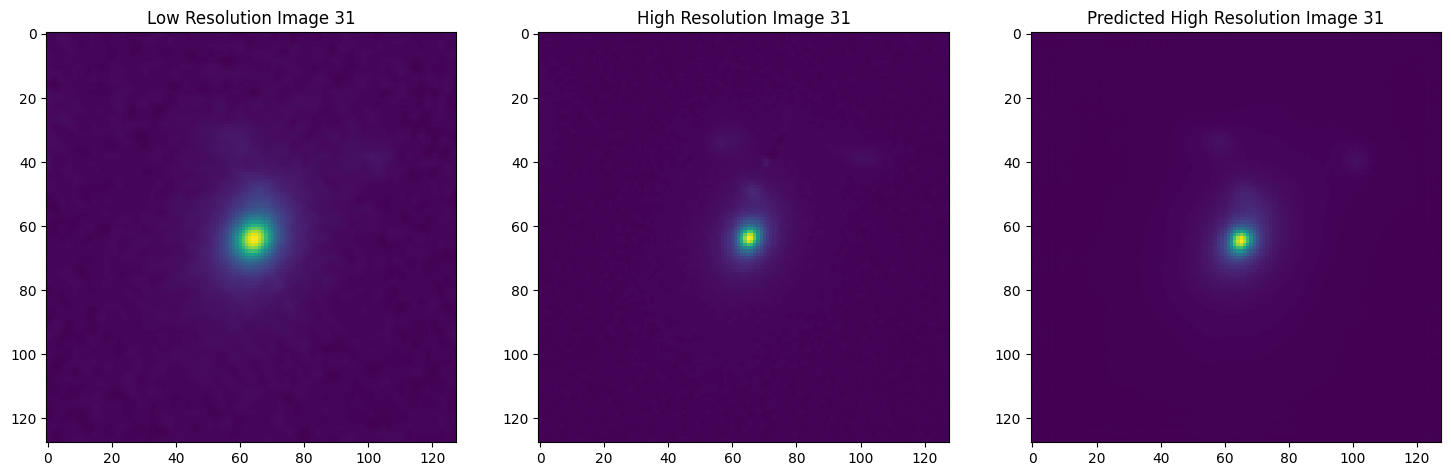

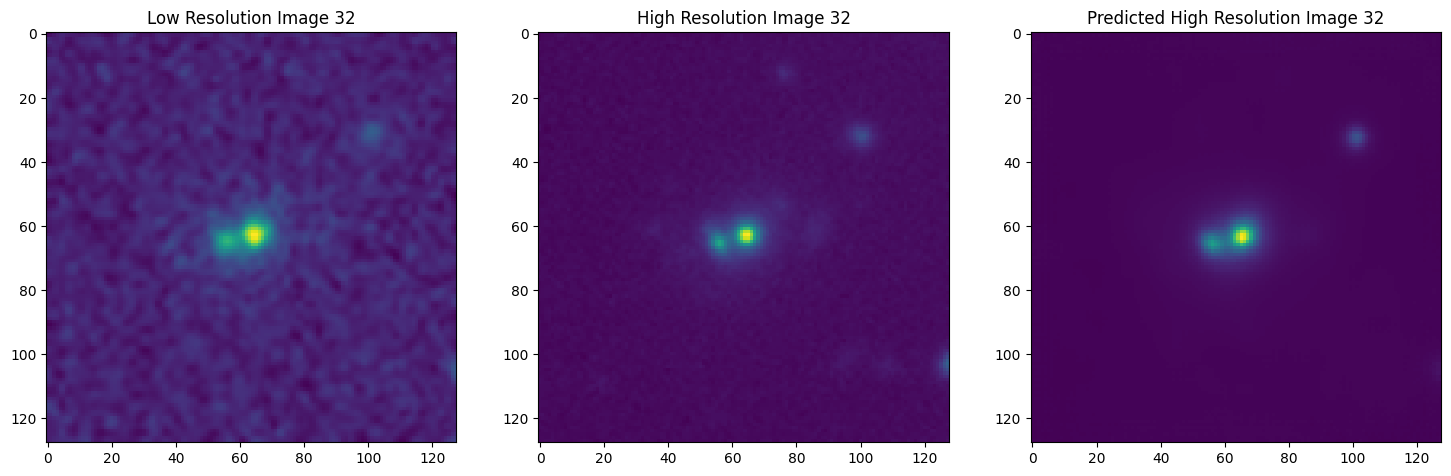

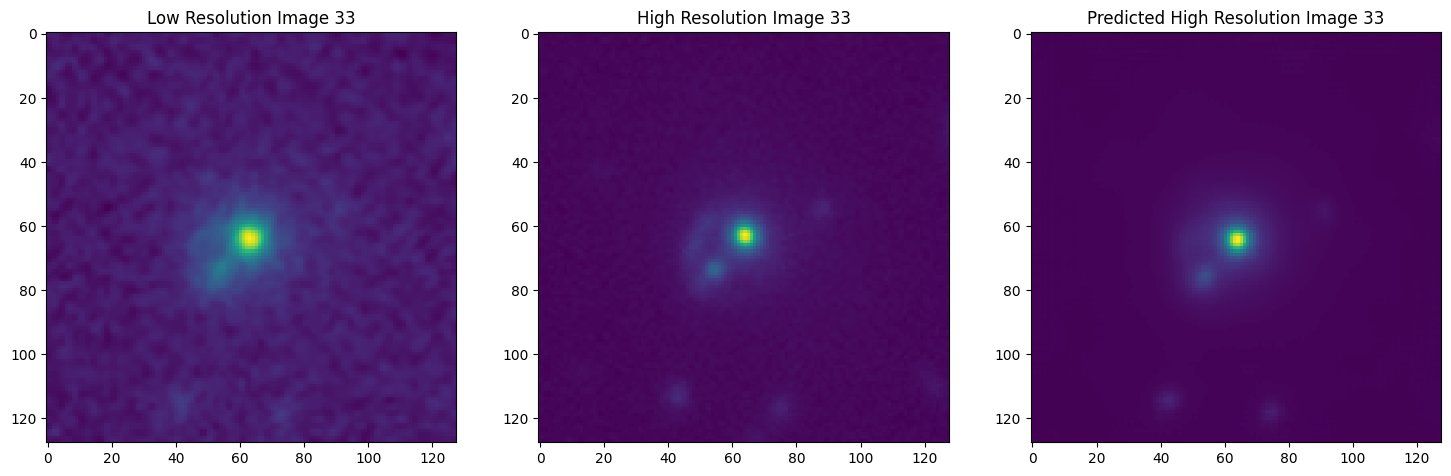

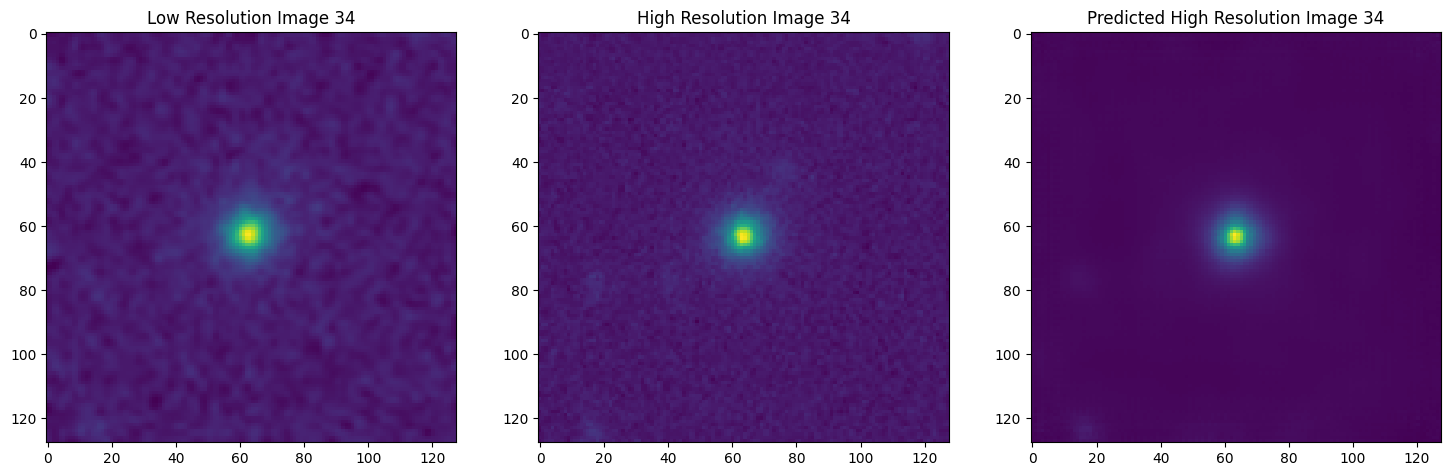

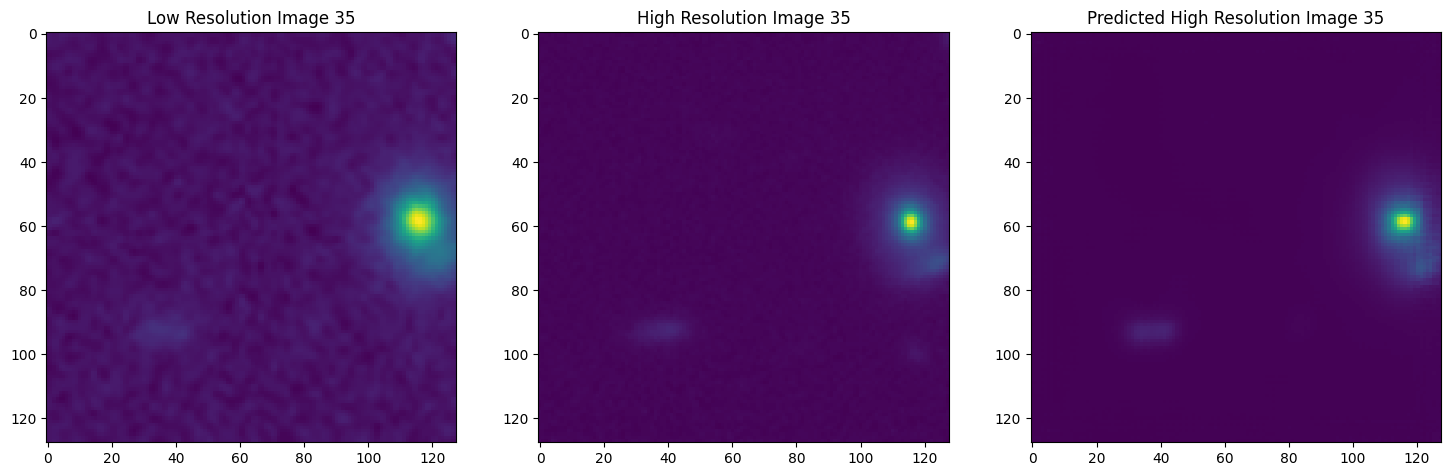

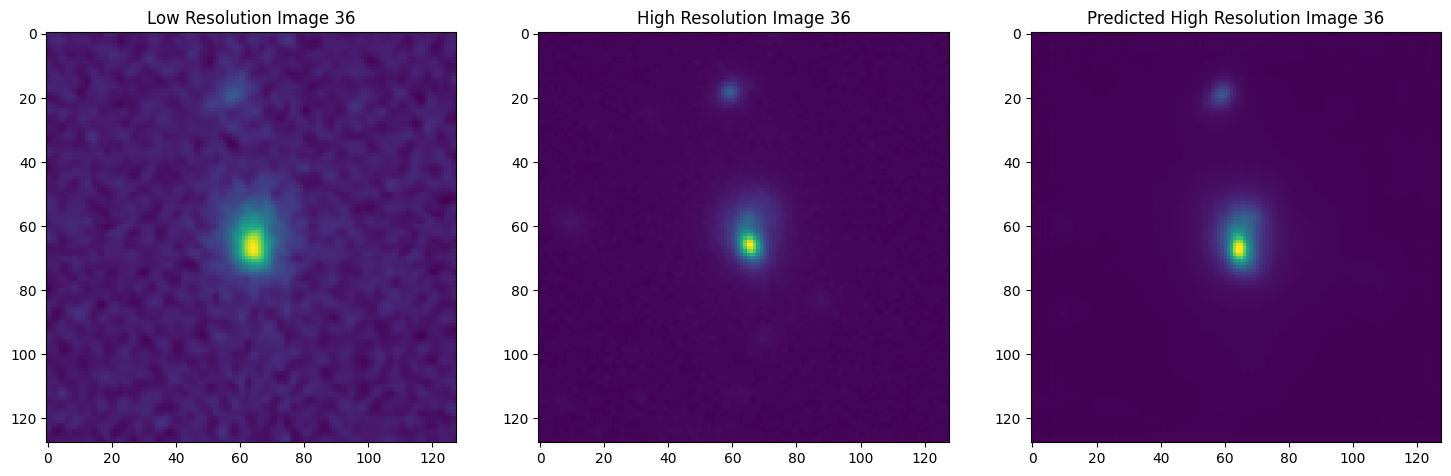

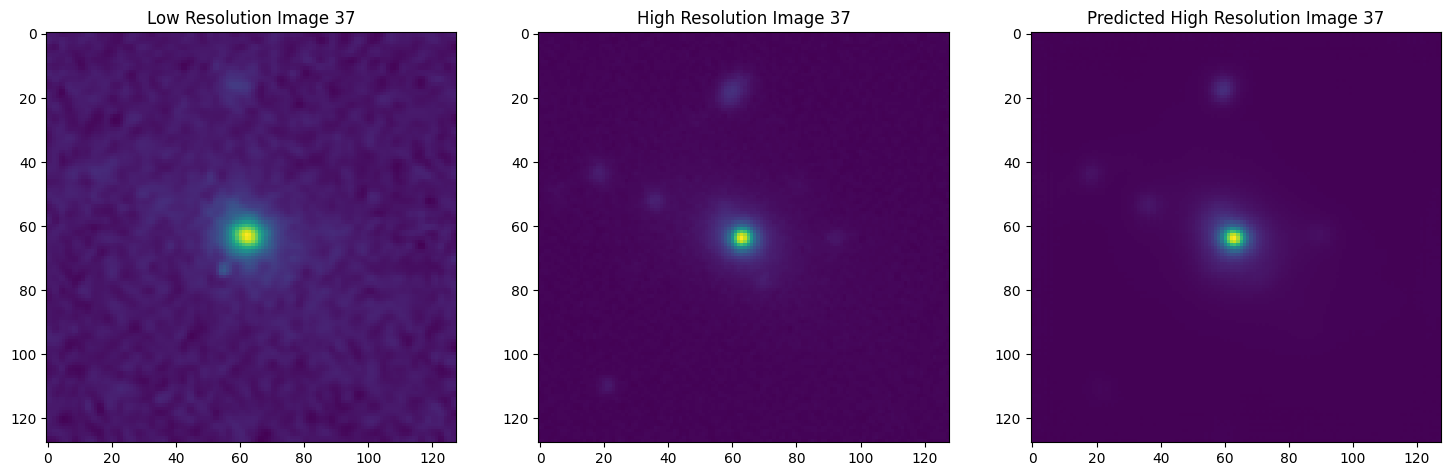

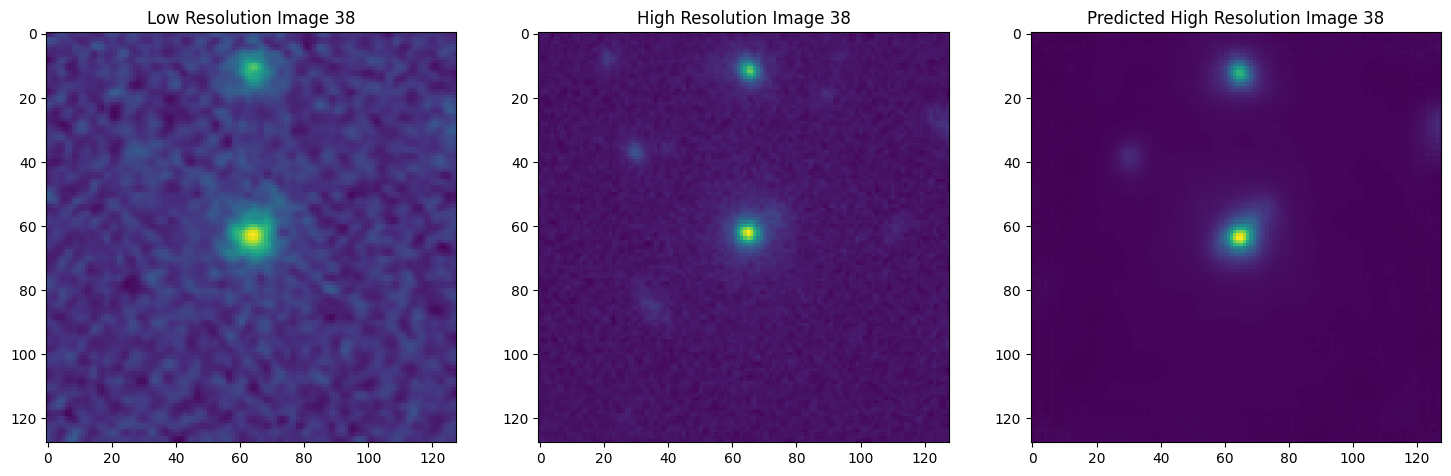

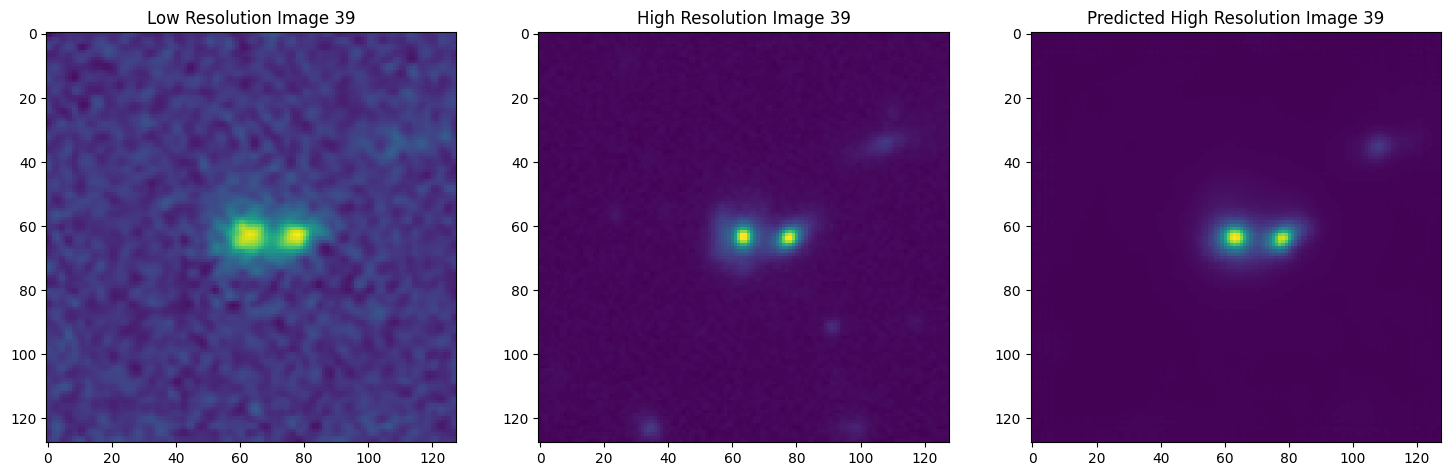

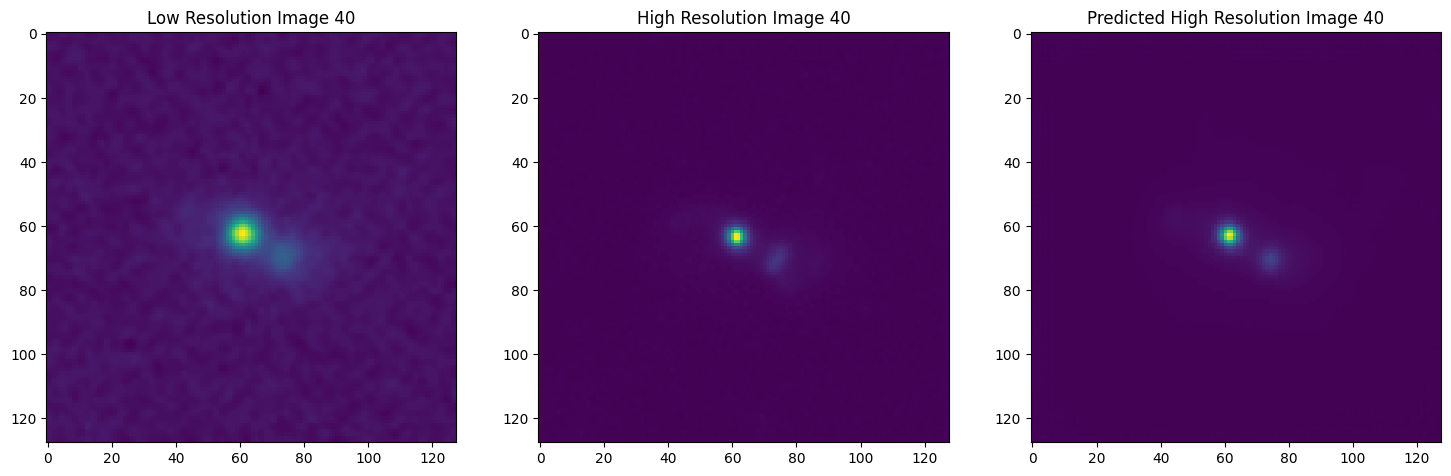

In [69]:
import torch
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, dataloader, device, T, num_batches=5):
    """
    Evaluates the model on the test dataloader and visualizes the results.

    Parameters:
    - model (nn.Module): The trained model.
    - dataloader (DataLoader): The dataloader for test data.
    - device (str): Device to perform computation on.
    - T (int): Number of timesteps.
    - num_batches (int): Number of batches to visualize.
    """
    model.eval()
    
    for i, (lr_batch, hr_batch) in enumerate(dataloader):
        if i >= num_batches:
            break
        
        lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
        timesteps = torch.randint(0, T, (lr_batch.size(0),), device=device).long()
        
        with torch.no_grad():
            noisy_images, _ = forward_diffusion_sample(hr_batch, timesteps, device=device)
            pred_hr_batch = model(noisy_images, lr_batch, timesteps)
        
        lr_batch = lr_batch.cpu().detach()
        hr_batch = hr_batch.cpu().detach()
        pred_hr_batch = pred_hr_batch.cpu().detach()
        
        for j in range(lr_batch.size(0)):
            lr = lr_batch[j].squeeze()
            hr = hr_batch[j].squeeze()
            pred_hr = pred_hr_batch[j].squeeze()
            
            plt.figure(figsize=(18, 6))
            
            plt.subplot(1, 3, 1)
            plt.imshow(lr, cmap='viridis')
            plt.title(f'Low Resolution Image {i*lr_batch.size(0) + j + 1}')
            
            plt.subplot(1, 3, 2)
            plt.imshow(hr, cmap='viridis')
            plt.title(f'High Resolution Image {i*lr_batch.size(0) + j + 1}')
            
            plt.subplot(1, 3, 3)
            plt.imshow(pred_hr, cmap='viridis')
            plt.title(f'Predicted High Resolution Image {i*lr_batch.size(0) + j + 1}')
            
            plt.show()

T=1000
evaluate_and_visualize(unet_model, test_loader, device, T)